# Stock Market Prediction Project
## Part 1: Support Vector Classifier for Stock Buying Decisions
## Part 2: ARIMA, SVR, XGBoost, and Neural Networks for Stock Price Prediction

**Project Overview:**
- Analyze 10 stocks from different industries
- Implement SVC for buying decisions
- Compare SARIMAX, SVR, XGBoost, and Neural Networks for price prediction
- Create comprehensive visualizations using Plotly
- Build equal-weight portfolio and compare with market indices

**Stocks Analyzed:**
1. HDFC Bank (Banking)
2. TCS (IT Services)
3. Maruti Suzuki (Automobile)
4. Asian Paints (Manufacturing)
5. Dabur (FMCG)
6. Dr. Reddy's (Healthcare)
7. Apollo Hospitals (Healthcare)
8. Airtel (Telecom)
9. Mazagon Dock (Shipyard)
10. Motilal Oswal (NBFC)


In [1]:
# Importing all necessary libraries
import sys
print(sys.executable)
print(sys.version)
!{sys.executable} -m pip install tensorflow --timeout=120
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)
from datetime import datetime, timedelta
import os
import glob

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


c:\Users\home\miniconda3\python.exe
3.9.5 (default, May 18 2021, 14:42:02) [MSC v.1916 64 bit (AMD64)]


All libraries imported successfully!
TensorFlow version: 2.20.0
Pandas version: 2.1.3
NumPy version: 1.26.2


## Data Loading and Preprocessing

In this section, we will:
1. Load all 10 stock datasets
2. Clean and standardize the data format
3. Handle missing values and outliers
4. Create consistent date indexing
5. Prepare data for both classification (buying decisions) and regression (price prediction) tasks


In [2]:

stocks_info = {
    'HDFC_BANK.csv': {'name': 'HDFC Bank', 'sector': 'Banking'},
    'TCS_IT.csv': {'name': 'TCS', 'sector': 'IT Services'},
    'Maruti_automobile.csv': {'name': 'Maruti Suzuki', 'sector': 'Automobile'},
    'Asianpaints_manufacturing.csv': {'name': 'Asian Paints', 'sector': 'Manufacturing'},
    'Dabur_fmcg.csv': {'name': 'Dabur', 'sector': 'FMCG'},
    'Dr.reddy_healthcare.csv': {'name': 'Dr. Reddy\'s', 'sector': 'Healthcare'},
    'APOLLO_Hospitals.csv': {'name': 'Apollo Hospitals', 'sector': 'Healthcare'},
    'Airtel_telecom.csv': {'name': 'Airtel', 'sector': 'Telecom'},
    'Mazagon_shipyard.csv': {'name': 'Mazagon Dock', 'sector': 'Shipyard'},
    'Motilal_oswal.csv': {'name': 'Motilal Oswal', 'sector': 'NBFC'}
}


def load_stock_data(filename, stock_name, sector):
    try:
        df = pd.read_csv(filename)
        

        print(f"\n=== {stock_name} ({sector}) ===")
        print(f"Original shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        
        df.columns = df.columns.str.strip()
        
        column_mapping = {
            'Date': 'Date',
            'Open Price': 'OPEN',
            'High Price': 'HIGH', 
            'Low Price': 'LOW',
            'Close Price': 'CLOSE',
            'Last Price': 'CLOSE',  
            'Total Traded Quantity': 'VOLUME'
        }
        
        for old_col, new_col in column_mapping.items():
            if old_col in df.columns and new_col not in df.columns:
                df[new_col] = df[old_col]
        
        
        required_cols = ['Date', 'OPEN', 'HIGH', 'LOW', 'CLOSE']
        missing_cols = [col for col in required_cols if col not in df.columns]
        
        if missing_cols:
            print(f"Warning: Missing columns {missing_cols} in {filename}")
            return None
        
        
        df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y', errors='coerce')
        
        
        df = df.dropna(subset=['Date'])
        
        
        price_cols = ['OPEN', 'HIGH', 'LOW', 'CLOSE']
        for col in price_cols:
            if col in df.columns:
                df[col] = df[col].astype(str).str.replace(',', '').astype(float)
        
       
        df = df.sort_values('Date').reset_index(drop=True)
        
        
        df = df.drop_duplicates(subset=['Date']).reset_index(drop=True)
        
        
        df['STOCK_NAME'] = stock_name
        df['SECTOR'] = sector
        

        df['RETURNS'] = df['CLOSE'].pct_change()
        df['VOLATILITY'] = df['RETURNS'].rolling(window=20).std()
        df['SMA_20'] = df['CLOSE'].rolling(window=20).mean()
        df['SMA_50'] = df['CLOSE'].rolling(window=50).mean()
        
        print(f"Processed shape: {df.shape}")
        print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
        print(f"Missing values: {df[price_cols].isnull().sum().sum()}")
        
        return df
        
    except Exception as e:
        print(f"Error loading {filename}: {str(e)}")
        return None


stocks_data = {}
for filename, info in stocks_info.items():
    if os.path.exists(filename):
        df = load_stock_data(filename, info['name'], info['sector'])
        if df is not None:
            stocks_data[info['name']] = df
    else:
        print(f"File not found: {filename}")

print(f"\nSuccessfully loaded {len(stocks_data)} stocks")
print("Available stocks:", list(stocks_data.keys()))



=== HDFC Bank (Banking) ===
Original shape: (773, 15)
Columns: ['Symbol  ', 'Series  ', 'Date  ', 'Prev Close  ', 'Open Price  ', 'High Price  ', 'Low Price  ', 'Last Price  ', 'Close Price  ', 'Average Price ', 'Total Traded Quantity  ', 'Turnover ₹  ', 'No. of Trades  ', 'Deliverable Qty  ', '% Dly Qt to Traded Qty  ']
Processed shape: (746, 26)
Date range: 2022-09-26 00:00:00 to 2025-09-25 00:00:00
Missing values: 0

=== TCS (IT Services) ===
Original shape: (754, 15)
Columns: ['Symbol  ', 'Series  ', 'Date  ', 'Prev Close  ', 'Open Price  ', 'High Price  ', 'Low Price  ', 'Last Price  ', 'Close Price  ', 'Average Price ', 'Total Traded Quantity  ', 'Turnover ₹  ', 'No. of Trades  ', 'Deliverable Qty  ', '% Dly Qt to Traded Qty  ']
Processed shape: (746, 26)
Date range: 2022-09-26 00:00:00 to 2025-09-25 00:00:00
Missing values: 0

=== Maruti Suzuki (Automobile) ===
Original shape: (750, 15)
Columns: ['Symbol  ', 'Series  ', 'Date  ', 'Prev Close  ', 'Open Price  ', 'High Price  ', 

In [3]:
for stock_name, df in stocks_data.items():
    sector = df['SECTOR'].iloc[0]

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=df['Date'],
        y=df['CLOSE'],
        mode='lines',
        line=dict(width=2, color='royalblue'),
        name='Close Price',
        hovertemplate=(
            f"<b>{stock_name}</b><br>"
            "Sector: %{meta[0]}<br>"
            "Date: %{x|%d-%b-%Y}<br>"
            "Close: ₹%{y:.2f}<extra></extra>"
        ),
        meta=[sector]
    ))

    if 'SMA_20' in df.columns and 'SMA_50' in df.columns:
        fig.add_trace(go.Scatter(
            x=df['Date'], y=df['SMA_20'],
            mode='lines', line=dict(dash='dot', color='orange', width=1.5),
            name='SMA 20'
        ))
        fig.add_trace(go.Scatter(
            x=df['Date'], y=df['SMA_50'],
            mode='lines', line=dict(dash='dot', color='green', width=1.5),
            name='SMA 50'
        ))

    fig.update_layout(
        title={
            'text': f"{stock_name} ({sector}) — Price Movement",
            'x': 0.5,
            'xanchor': 'center',
            'font': dict(size=22)
        },
        xaxis_title="Date",
        yaxis_title="Close Price (INR)",
        hovermode="x unified",
        legend_title="Indicators",
        template="plotly_white",
        height=500,
        width=900
    )

    fig.show()


In [4]:
# Data Preparation for Machine Learning Models

def prepare_features_and_target(df, stock_name):
    df_processed = df.copy()
    df_processed.index = pd.to_datetime(df_processed['Date'])
    df_processed = df_processed.drop(['Date'], axis='columns')
    df_processed['Open-Close'] = df_processed['OPEN'] - df_processed['CLOSE']
    df_processed['High-Low'] = df_processed['HIGH'] - df_processed['LOW']
    df_processed['Return'] = df_processed['CLOSE'].pct_change()
    df_processed['MA5'] = df_processed['CLOSE'].rolling(5).mean()
    df_processed['MA10'] = df_processed['CLOSE'].rolling(10).mean()
    df_processed['Momentum'] = df_processed['CLOSE'] - df_processed['CLOSE'].shift(5)
    features = ['Open-Close', 'High-Low', 'Return', 'MA5', 'MA10', 'Momentum']
    X = df_processed[features].shift(1)
    y = np.where(df_processed['CLOSE'].shift(-1) > df_processed['CLOSE'], 1, 0)
    X = X[:-1]
    y = y[:-1]
    
    print(f"\n{stock_name} - Features and Target prepared:")
    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    print(f"Buy signals (1): {np.sum(y == 1)}")
    print(f"No position signals (0): {np.sum(y == 0)}")
    
    return X, y, df_processed
    
stocks_features = {}
stocks_targets = {}
stocks_processed = {}

for stock_name, df in stocks_data.items():
    X, y, df_proc = prepare_features_and_target(df, stock_name)
    stocks_features[stock_name] = X
    stocks_targets[stock_name] = y
    stocks_processed[stock_name] = df_proc

print(f"\nData preparation completed for {len(stocks_features)} stocks")



HDFC Bank - Features and Target prepared:
Features shape: (745, 6)
Target shape: (745,)
Buy signals (1): 390
No position signals (0): 355

TCS - Features and Target prepared:
Features shape: (745, 6)
Target shape: (745,)
Buy signals (1): 355
No position signals (0): 390

Maruti Suzuki - Features and Target prepared:
Features shape: (745, 6)
Target shape: (745,)
Buy signals (1): 365
No position signals (0): 380

Asian Paints - Features and Target prepared:
Features shape: (745, 6)
Target shape: (745,)
Buy signals (1): 375
No position signals (0): 370

Dabur - Features and Target prepared:
Features shape: (745, 6)
Target shape: (745,)
Buy signals (1): 372
No position signals (0): 373

Dr. Reddy's - Features and Target prepared:
Features shape: (745, 6)
Target shape: (745,)
Buy signals (1): 395
No position signals (0): 350

Apollo Hospitals - Features and Target prepared:
Features shape: (746, 6)
Target shape: (746,)
Buy signals (1): 367
No position signals (0): 379

Airtel - Features an

In [5]:
px.line

<function plotly.express._chart_types.line(data_frame=None, x=None, y=None, line_group=None, color=None, line_dash=None, symbol=None, hover_name=None, hover_data=None, custom_data=None, text=None, facet_row=None, facet_col=None, facet_col_wrap=0, facet_row_spacing=None, facet_col_spacing=None, error_x=None, error_x_minus=None, error_y=None, error_y_minus=None, animation_frame=None, animation_group=None, category_orders=None, labels=None, orientation=None, color_discrete_sequence=None, color_discrete_map=None, line_dash_sequence=None, line_dash_map=None, symbol_sequence=None, symbol_map=None, markers=False, log_x=False, log_y=False, range_x=None, range_y=None, line_shape=None, render_mode='auto', title=None, template=None, width=None, height=None) -> plotly.graph_objs._figure.Figure>

## Part 1: Support Vector Classifier for Stock Buying Decisions

In this section, we will:
1. Implement SVC for each stock to predict buying decisions
2. Use TimeSeriesSplit for proper time series cross-validation
3. Compare cumulative returns from SVC predictions vs actual returns
4. Create visualizations showing the performance


In [6]:
# Part 1: Support Vector Classifier Implementation

def train_svc_model(X, y, stock_name, test_size=0.2):
    print(f"\n=== Training SVC for {stock_name} ===")
    
    split_percentage = 1 - test_size
    split = int(split_percentage * len(X))
    
    X_train = X[:split]
    y_train = y[:split]
    
    X_test = X[split:]
    y_test = y[split:]
    
    print(f"Training set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    svc = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
    
    svc.fit(X_train_scaled, y_train)
    
    y_pred_test = svc.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred_test)
    
    print(f"SVC Accuracy: {accuracy:.4f}")
    print(f"Test predictions sample: {y_pred_test[:5]}")
    
    return {
        'model': svc,
        'scaler': scaler,
        'y_test': y_test,
        'y_pred_test': y_pred_test,
        'accuracy': accuracy,
        'X_test': X_test,
        'X_train': X_train,
        'y_train': y_train
    }
svc_results = {}

for stock_name in stocks_features.keys():
    X = stocks_features[stock_name]
    y = stocks_targets[stock_name]
    valid_indices = ~(X.isnull().any(axis=1) | pd.isnull(y))
    X_clean = X[valid_indices]
    y_clean = y[valid_indices]
    
    if len(X_clean) > 100: 
        result = train_svc_model(X_clean, y_clean, stock_name)
        svc_results[stock_name] = result
    else:
        print(f"Skipping {stock_name} - insufficient data")

print(f"\nSVC training completed for {len(svc_results)} stocks")



=== Training SVC for HDFC Bank ===
Training set size: 588
Test set size: 147
SVC Accuracy: 0.4966
Test predictions sample: [1 1 1 0 1]

=== Training SVC for TCS ===
Training set size: 588
Test set size: 147
SVC Accuracy: 0.4558
Test predictions sample: [0 0 0 0 1]

=== Training SVC for Maruti Suzuki ===
Training set size: 588
Test set size: 147
SVC Accuracy: 0.4694
Test predictions sample: [0 0 0 0 1]

=== Training SVC for Asian Paints ===
Training set size: 588
Test set size: 147
SVC Accuracy: 0.4830
Test predictions sample: [0 0 0 0 0]

=== Training SVC for Dabur ===
Training set size: 588
Test set size: 147
SVC Accuracy: 0.5102
Test predictions sample: [1 1 1 1 1]

=== Training SVC for Dr. Reddy's ===
Training set size: 588
Test set size: 147
SVC Accuracy: 0.4558
Test predictions sample: [0 0 0 0 0]

=== Training SVC for Apollo Hospitals ===
Training set size: 588
Test set size: 148
SVC Accuracy: 0.4392
Test predictions sample: [1 1 1 1 1]

=== Training SVC for Airtel ===
Training 

In [7]:
# Calculate Cumulative Returns for SVC Predictions vs Actual Returns

def calculate_cumulative_returns(stock_name, svc_result, stock_data):
    
    test_size = len(svc_result['y_test'])
    total_size = len(stock_data)
    train_size = total_size - test_size
    
    test_prices = stock_data['CLOSE'].iloc[train_size:train_size + test_size].values
    test_dates = stock_data['Date'].iloc[train_size:train_size + test_size].values
    actual_returns = np.diff(test_prices) / test_prices[:-1]
    svc_predictions = svc_result['y_pred_test']
    signals = svc_predictions[:-1]
    svc_returns = np.where(signals == 1, actual_returns, 0)
    actual_cumulative = np.cumprod(1 + actual_returns) - 1
    svc_cumulative = np.cumprod(1 + svc_returns) - 1
    buy_hold_cumulative = actual_cumulative.copy()
    
    return {
        'stock_name': stock_name,
        'dates': test_dates[1:], 
        'actual_cumulative': actual_cumulative,
        'svc_cumulative': svc_cumulative,
        'buy_hold_cumulative': buy_hold_cumulative,
        'actual_returns': actual_returns,
        'svc_returns': svc_returns,
        'svc_predictions': svc_predictions[:-1]  
    }

cumulative_returns = {}

for stock_name in svc_results.keys():
    if stock_name in stocks_data:
        result = calculate_cumulative_returns(stock_name, svc_results[stock_name], stocks_data[stock_name])
        cumulative_returns[stock_name] = result
        
        # Print summary
        final_actual = result['actual_cumulative'][-1]
        final_svc = result['svc_cumulative'][-1]
        final_buy_hold = result['buy_hold_cumulative'][-1]
        
        print(f"\n{stock_name} - Cumulative Returns:")
        print(f"Actual Returns: {final_actual:.4f} ({final_actual*100:.2f}%)")
        print(f"SVC Strategy: {final_svc:.4f} ({final_svc*100:.2f}%)")
        print(f"Buy & Hold: {final_buy_hold:.4f} ({final_buy_hold*100:.2f}%)")
        print(f"SVC vs Buy & Hold: {final_svc - final_buy_hold:.4f} ({(final_svc - final_buy_hold)*100:.2f}%)")

print(f"\nCumulative returns calculated for {len(cumulative_returns)} stocks")



HDFC Bank - Cumulative Returns:
Actual Returns: -0.4370 (-43.70%)
SVC Strategy: 0.1109 (11.09%)
Buy & Hold: -0.4370 (-43.70%)
SVC vs Buy & Hold: 0.5479 (54.79%)

TCS - Cumulative Returns:
Actual Returns: -0.2175 (-21.75%)
SVC Strategy: -0.1171 (-11.71%)
Buy & Hold: -0.2175 (-21.75%)
SVC vs Buy & Hold: 0.1004 (10.04%)

Maruti Suzuki - Cumulative Returns:
Actual Returns: 0.3077 (30.77%)
SVC Strategy: -0.0118 (-1.18%)
Buy & Hold: 0.3077 (30.77%)
SVC vs Buy & Hold: -0.3196 (-31.96%)

Asian Paints - Cumulative Returns:
Actual Returns: 0.0689 (6.89%)
SVC Strategy: 0.0000 (0.00%)
Buy & Hold: 0.0689 (6.89%)
SVC vs Buy & Hold: -0.0689 (-6.89%)

Dabur - Cumulative Returns:
Actual Returns: -0.0079 (-0.79%)
SVC Strategy: -0.0233 (-2.33%)
Buy & Hold: -0.0079 (-0.79%)
SVC vs Buy & Hold: -0.0153 (-1.53%)

Dr. Reddy's - Cumulative Returns:
Actual Returns: 0.0890 (8.90%)
SVC Strategy: -0.0121 (-1.21%)
Buy & Hold: 0.0890 (8.90%)
SVC vs Buy & Hold: -0.1011 (-10.11%)

Apollo Hospitals - Cumulative Return

In [8]:
def create_equal_weight_portfolio(cumulative_returns_data):
    stock_names = list(cumulative_returns_data.keys())
    n_stocks = len(stock_names)
    min_length = min(len(data['svc_cumulative']) for data in cumulative_returns_data.values())
    portfolio_svc_returns = np.zeros(min_length)
    portfolio_buy_hold_returns = np.zeros(min_length)
    portfolio_actual_returns = np.zeros(min_length)
    for stock_name, data in cumulative_returns_data.items():
        svc_returns = data['svc_returns'][:min_length]
        buy_hold_returns = data['actual_returns'][:min_length]
        actual_returns = data['actual_returns'][:min_length]
        portfolio_svc_returns += svc_returns / n_stocks
        portfolio_buy_hold_returns += buy_hold_returns / n_stocks
        portfolio_actual_returns += actual_returns / n_stocks

    portfolio_svc_cumulative = np.cumprod(1 + portfolio_svc_returns) - 1
    portfolio_buy_hold_cumulative = np.cumprod(1 + portfolio_buy_hold_returns) - 1
    portfolio_actual_cumulative = np.cumprod(1 + portfolio_actual_returns) - 1
    first_stock_data = list(cumulative_returns_data.values())[0]
    portfolio_dates = first_stock_data['dates'][:min_length]
    
    return {
        'dates': portfolio_dates,
        'portfolio_svc_cumulative': portfolio_svc_cumulative,
        'portfolio_buy_hold_cumulative': portfolio_buy_hold_cumulative,
        'portfolio_actual_cumulative': portfolio_actual_cumulative,
        'portfolio_svc_returns': portfolio_svc_returns,
        'portfolio_buy_hold_returns': portfolio_buy_hold_returns,
        'portfolio_actual_returns': portfolio_actual_returns,
        'stock_names': stock_names,
        'n_stocks': n_stocks
    }

if cumulative_returns:
    portfolio_data = create_equal_weight_portfolio(cumulative_returns)
    final_svc = portfolio_data['portfolio_svc_cumulative'][-1]
    final_buy_hold = portfolio_data['portfolio_buy_hold_cumulative'][-1]
    final_actual = portfolio_data['portfolio_actual_cumulative'][-1]
    
    print(f"\n=== Equal-Weight Portfolio Performance ===")
    print(f"Number of stocks: {portfolio_data['n_stocks']}")
    print(f"Stocks included: {', '.join(portfolio_data['stock_names'])}")
    print(f"\nPortfolio Cumulative Returns:")
    print(f"SVC Strategy: {final_svc:.4f} ({final_svc*100:.2f}%)")
    print(f"Buy & Hold: {final_buy_hold:.4f} ({final_buy_hold*100:.2f}%)")
    print(f"Actual Returns: {final_actual:.4f} ({final_actual*100:.2f}%)")
    print(f"SVC vs Buy & Hold: {final_svc - final_buy_hold:.4f} ({(final_svc - final_buy_hold)*100:.2f}%)")
    
    portfolio_volatility = np.std(portfolio_data['portfolio_svc_returns']) * np.sqrt(252)
    portfolio_sharpe = (final_svc * 252) / (portfolio_volatility * np.sqrt(252)) if portfolio_volatility > 0 else 0
    
    print(f"\nPortfolio Statistics:")
    print(f"Annualized Volatility: {portfolio_volatility:.4f} ({portfolio_volatility*100:.2f}%)")
    print(f"Sharpe Ratio: {portfolio_sharpe:.4f}")
else:
    print("No cumulative returns data available for portfolio creation")



=== Equal-Weight Portfolio Performance ===
Number of stocks: 10
Stocks included: HDFC Bank, TCS, Maruti Suzuki, Asian Paints, Dabur, Dr. Reddy's, Apollo Hospitals, Airtel, Mazagon Dock, Motilal Oswal

Portfolio Cumulative Returns:
SVC Strategy: 0.0245 (2.45%)
Buy & Hold: 0.0980 (9.80%)
Actual Returns: 0.0980 (9.80%)
SVC vs Buy & Hold: -0.0736 (-7.36%)

Portfolio Statistics:
Annualized Volatility: 0.0570 (5.70%)
Sharpe Ratio: 6.8130


In [9]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def create_svc_performance_visualization(cumulative_returns_data, portfolio_data, svc_results):
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=[
            'Individual Stock: SVC vs Buy & Hold Returns',
            'Portfolio Performance Over Time',
            'Model Prediction Accuracy per Stock',
            'Cumulative SVC Returns (Top 5 Stocks)',
            'Distribution of Daily Returns',
            'Risk vs Return (SVC Strategy)'
        ],
        specs=[[{}, {}], [{}, {}], [{}, {}]],
        horizontal_spacing=0.08,
        vertical_spacing=0.1
    )

    stock_names = list(cumulative_returns_data.keys())
    svc_final_returns = []
    buy_hold_final_returns = []

    for stock_name in stock_names:
        data = cumulative_returns_data[stock_name]
        svc_final_returns.append(data['svc_cumulative'][-1] * 100)
        buy_hold_final_returns.append(data['buy_hold_cumulative'][-1] * 100)

    fig.add_trace(
        go.Bar(
            name='SVC Strategy',
            x=stock_names,
            y=svc_final_returns,
            marker_color='royalblue',
            text=[f"{v:.2f}%" for v in svc_final_returns],
            textposition="outside",
            hovertemplate="<b>%{x}</b><br>SVC Return: %{y:.2f}%<extra></extra>"
        ),
        row=1, col=1
    )
    fig.add_trace(
        go.Bar(
            name='Buy & Hold',
            x=stock_names,
            y=buy_hold_final_returns,
            marker_color='indianred',
            text=[f"{v:.2f}%" for v in buy_hold_final_returns],
            textposition="outside",
            hovertemplate="<b>%{x}</b><br>Buy & Hold: %{y:.2f}%<extra></extra>"
        ),
        row=1, col=1
    )

    if portfolio_data:
        dates = portfolio_data['dates']
        fig.add_trace(
            go.Scatter(
                x=dates,
                y=portfolio_data['portfolio_svc_cumulative'] * 100,
                mode='lines',
                name='Portfolio SVC',
                line=dict(color='royalblue', width=2.5),
                hovertemplate="Date: %{x|%d-%b-%Y}<br>SVC Portfolio: %{y:.2f}%<extra></extra>"
            ),
            row=1, col=2
        )
        fig.add_trace(
            go.Scatter(
                x=dates,
                y=portfolio_data['portfolio_buy_hold_cumulative'] * 100,
                mode='lines',
                name='Portfolio Buy & Hold',
                line=dict(color='firebrick', width=2.5),
                hovertemplate="Date: %{x|%d-%b-%Y}<br>Buy & Hold: %{y:.2f}%<extra></extra>"
            ),
            row=1, col=2
        )

    accuracies = [svc_results.get(s, {}).get('accuracy', 0) * 100 for s in stock_names]
    fig.add_trace(
        go.Bar(
            x=stock_names,
            y=accuracies,
            marker_color='mediumseagreen',
            text=[f"{a:.1f}%" for a in accuracies],
            textposition="outside",
            hovertemplate="<b>%{x}</b><br>Accuracy: %{y:.2f}%<extra></extra>"
        ),
        row=2, col=1
    )

    colors = ['royalblue', 'orange', 'green', 'purple', 'brown']
    for i, (stock_name, data) in enumerate(list(cumulative_returns_data.items())[:5]):
        fig.add_trace(
            go.Scatter(
                x=data['dates'],
                y=data['svc_cumulative'] * 100,
                mode='lines',
                name=f"{stock_name} SVC",
                line=dict(color=colors[i], width=1.8),
                hovertemplate="Date: %{x|%d-%b-%Y}<br>%{fullData.name}: %{y:.2f}%<extra></extra>"
            ),
            row=2, col=2
        )


    if portfolio_data:
        fig.add_trace(
            go.Histogram(
                x=portfolio_data['portfolio_svc_returns'],
                name='SVC Returns',
                opacity=0.7,
                marker_color='royalblue',
                nbinsx=40
            ),
            row=3, col=1
        )
        fig.add_trace(
            go.Histogram(
                x=portfolio_data['portfolio_buy_hold_returns'],
                name='Buy & Hold Returns',
                opacity=0.6,
                marker_color='firebrick',
                nbinsx=40
            ),
            row=3, col=1
        )

    risks, returns = [], []
    for stock_name, data in cumulative_returns_data.items():
        stock_returns = data['svc_returns']
        risks.append(np.std(stock_returns) * np.sqrt(252) * 100)
        returns.append(data['svc_cumulative'][-1] * 100)
    fig.add_trace(
        go.Scatter(
            x=risks,
            y=returns,
            mode='markers+text',
            text=stock_names,
            textposition="top center",
            marker=dict(size=10, color='royalblue', line=dict(width=1, color='white')),
            hovertemplate="<b>%{text}</b><br>Risk: %{x:.2f}%<br>Return: %{y:.2f}%<extra></extra>"
        ),
        row=3, col=2
    )

    fig.update_layout(
        title={
            'text': "SVC Model Stock Market Prediction Performance Dashboard",
            'x': 0.5,
            'font': dict(size=24, family="Arial Black")
        },
        template="plotly_white",
        barmode="group",
        height=1300,
        width=1200,
        legend=dict(
            orientation="h",
            yanchor="bottom", y=-0.2,
            xanchor="center", x=0.5,
            bgcolor="rgba(255,255,255,0.7)"
        )
    )
    axis_titles = [
        ("Stocks", "Returns (%)"),
        ("Date", "Portfolio Returns (%)"),
        ("Stocks", "Accuracy (%)"),
        ("Date", "Cumulative Returns (%)"),
        ("Daily Returns", "Frequency"),
        ("Risk (Volatility %)", "Return (%)")
    ]
    for i, (x_title, y_title) in enumerate(axis_titles, start=1):
        r, c = divmod(i-1, 2)
        fig.update_xaxes(title_text=x_title, row=r+1, col=c+1)
        fig.update_yaxes(title_text=y_title, row=r+1, col=c+1)

    fig.show()
create_svc_performance_visualization(cumulative_returns, portfolio_data, svc_results)


## Part 2: ARIMA, SVR, XGBoost, and Neural Networks for Stock Price Prediction

In this section, we will:
1. Implement SARIMAX for time series forecasting
2. Use Support Vector Regression (SVR) for price prediction
3. Apply XGBoost for enhanced prediction accuracy
4. Build Neural Networks (LSTM/GRU) for deep learning approach
5. Compare all models using MSE, MAE, and R² metrics
6. Create comprehensive visualizations


In [10]:
# Part 2: SARIMAX Implementation for Stock Price Prediction

def prepare_sarimax_data(df, stock_name, target_col='CLOSE'):
    df_processed = df.copy()
    df_processed.index = pd.to_datetime(df_processed['Date'])

    for col in ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME']:
        if col in df_processed.columns:
            df_processed[col] = (
                df_processed[col]
                .astype(str)
                .str.replace(',', '', regex=True)
                .astype(float)
            )

    df_processed['Open-Close'] = df_processed['OPEN'] - df_processed['CLOSE']
    df_processed['High-Low'] = df_processed['HIGH'] - df_processed['LOW']
    df_processed['Volume'] = df_processed.get('VOLUME', 1)

    exog_vars = ['Open-Close', 'High-Low', 'Volume']
    exog_data = df_processed[exog_vars].fillna(method='ffill').fillna(0)

    scaler = StandardScaler()
    exog_data_scaled = pd.DataFrame(
        scaler.fit_transform(exog_data),
        columns=exog_vars,
        index=exog_data.index
    )

    target_data = df_processed[target_col].dropna()

    common_index = target_data.index.intersection(exog_data_scaled.index)
    target_data = target_data.loc[common_index]
    exog_data_scaled = exog_data_scaled.loc[common_index]

    split_point = int(0.8 * len(target_data))
    train_target = target_data[:split_point]
    test_target = target_data[split_point:]
    train_exog = exog_data_scaled[:split_point]
    test_exog = exog_data_scaled[split_point:]

    print(f"{stock_name} - SARIMAX Data Preparation:")
    print(f"Training period: {train_target.index[0]} to {train_target.index[-1]}")
    print(f"Testing period: {test_target.index[0]} to {test_target.index[-1]}")
    print(f"Training samples: {len(train_target)} | Testing samples: {len(test_target)}")

    return train_target, test_target, train_exog, test_exog

def choose_best_sarimax_order(train_target, train_exog):
    p = d = q = range(0, 2)
    seasonal_periods = [0, 12]
    best_aic = np.inf
    best_order = (1, 1, 1)
    best_seasonal = (1, 1, 1, 12)
    for i in p:
        for j in d:
            for k in q:
                for sp in seasonal_periods:
                    try:
                        seasonal_order = (1, 1, 1, sp) if sp > 0 else (0, 0, 0, 0)
                        model = SARIMAX(
                            train_target,
                            exog=train_exog,
                            order=(i, j, k),
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False
                        )
                        results = model.fit(disp=False, maxiter=30)
                        if results.aic < best_aic:
                            best_aic = results.aic
                            best_order = (i, j, k)
                            best_seasonal = seasonal_order
                    except:
                        continue
    return best_order, best_seasonal

def fit_sarimax_model(train_target, train_exog, stock_name):
    try:
        best_order, best_seasonal = choose_best_sarimax_order(train_target, train_exog)
        print(f"{stock_name} - Selected order={best_order}, seasonal_order={best_seasonal}")
        model = SARIMAX(
            train_target,
            exog=train_exog,
            order=best_order,
            seasonal_order=best_seasonal,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        fitted_model = model.fit(disp=False, maxiter=50)
        print(f"{stock_name} - SARIMAX fitted | AIC: {fitted_model.aic:.2f} | BIC: {fitted_model.bic:.2f}")
        return fitted_model
    except Exception as e:
        print(f"{stock_name} - Auto SARIMAX failed: {e}")
        try:
            model = SARIMAX(
                train_target,
                order=(1, 1, 1),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            fitted_model = model.fit(disp=False)
            print(f"{stock_name} - Simple SARIMAX fitted successfully")
            return fitted_model
        except Exception as e2:
            print(f"{stock_name} - Simple SARIMAX also failed: {e2}")
            return None

def predict_sarimax(model, test_exog, steps):
    try:
        if model is None:
            return np.full(steps, np.nan)
        predictions = model.forecast(steps=steps, exog=test_exog)
        return predictions.values if hasattr(predictions, 'values') else predictions
    except Exception as e:
        print(f"SARIMAX prediction error: {e}")
        return np.full(steps, np.nan)

sarimax_results = {}

for stock_name, df in stocks_data.items():
    print(f"\n{'='*50}")
    print(f"Processing {stock_name} for SARIMAX")
    print(f"{'='*50}")
    train_target, test_target, train_exog, test_exog = prepare_sarimax_data(df, stock_name)
    model = fit_sarimax_model(train_target, train_exog, stock_name)
    if model is not None:
        predictions = predict_sarimax(model, test_exog, len(test_target))
        mse = mean_squared_error(test_target, predictions)
        mae = mean_absolute_error(test_target, predictions)
        r2 = r2_score(test_target, predictions)
        sarimax_results[stock_name] = {
            'model': model,
            'predictions': predictions,
            'actual': test_target.values,
            'dates': test_target.index,
            'mse': mse,
            'mae': mae,
            'r2': r2,
            'train_target': train_target,
            'test_target': test_target
        }
        print(f"{stock_name} - SARIMAX Performance:")
        print(f"MSE: {mse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")
    else:
        print(f"{stock_name} - SARIMAX model could not be fitted")

print(f"\nSARIMAX models completed for {len(sarimax_results)} stocks")




Processing HDFC Bank for SARIMAX
HDFC Bank - SARIMAX Data Preparation:
Training period: 2022-09-26 00:00:00 to 2025-02-14 00:00:00
Testing period: 2025-02-17 00:00:00 to 2025-09-25 00:00:00
Training samples: 596 | Testing samples: 150


c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date inde

HDFC Bank - Selected order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)
HDFC Bank - SARIMAX fitted | AIC: 7075.98 | BIC: 7110.73
HDFC Bank - SARIMAX Performance:
MSE: 130618.4022 | MAE: 264.0712 | R²: -0.0896

Processing TCS for SARIMAX
TCS - SARIMAX Data Preparation:
Training period: 2022-09-26 00:00:00 to 2025-02-14 00:00:00
Testing period: 2025-02-17 00:00:00 to 2025-09-25 00:00:00
Training samples: 596 | Testing samples: 150


c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been prov

TCS - Selected order=(0, 1, 1), seasonal_order=(1, 1, 1, 12)


c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



TCS - SARIMAX fitted | AIC: 5700.97 | BIC: 5731.38
TCS - SARIMAX Performance:
MSE: 551628.9969 | MAE: 691.5533 | R²: -11.0210

Processing Maruti Suzuki for SARIMAX
Maruti Suzuki - SARIMAX Data Preparation:
Training period: 2022-09-26 00:00:00 to 2025-02-14 00:00:00
Testing period: 2025-02-17 00:00:00 to 2025-09-25 00:00:00
Training samples: 596 | Testing samples: 150


c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date inde

Maruti Suzuki - Selected order=(0, 1, 1), seasonal_order=(1, 1, 1, 12)
Maruti Suzuki - SARIMAX fitted | AIC: 6877.21 | BIC: 6907.62
Maruti Suzuki - SARIMAX Performance:
MSE: 1153808.9252 | MAE: 973.0958 | R²: 0.2030

Processing Asian Paints for SARIMAX
Asian Paints - SARIMAX Data Preparation:
Training period: 2022-09-26 00:00:00 to 2025-02-14 00:00:00
Testing period: 2025-02-17 00:00:00 to 2025-09-25 00:00:00
Training samples: 596 | Testing samples: 150


c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been prov

Asian Paints - Selected order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)


c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Asian Paints - SARIMAX fitted | AIC: 5331.18 | BIC: 5365.94
Asian Paints - SARIMAX Performance:
MSE: 124166.8414 | MAE: 300.5194 | R²: -9.6328

Processing Dabur for SARIMAX
Dabur - SARIMAX Data Preparation:
Training period: 2022-09-26 00:00:00 to 2025-02-14 00:00:00
Testing period: 2025-02-17 00:00:00 to 2025-09-25 00:00:00
Training samples: 596 | Testing samples: 150


c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been prov

Dabur - Selected order=(0, 1, 1), seasonal_order=(1, 1, 1, 12)
Dabur - SARIMAX fitted | AIC: 3532.62 | BIC: 3563.03
Dabur - SARIMAX Performance:
MSE: 846.6668 | MAE: 24.7153 | R²: -0.5681

Processing Dr. Reddy's for SARIMAX
Dr. Reddy's - SARIMAX Data Preparation:
Training period: 2022-09-26 00:00:00 to 2025-02-14 00:00:00
Testing period: 2025-02-17 00:00:00 to 2025-09-25 00:00:00
Training samples: 596 | Testing samples: 150


c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been prov

Dr. Reddy's - Selected order=(0, 1, 1), seasonal_order=(1, 1, 1, 12)


c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Dr. Reddy's - SARIMAX fitted | AIC: 7811.68 | BIC: 7842.08
Dr. Reddy's - SARIMAX Performance:
MSE: 642075.9470 | MAE: 692.2737 | R²: -139.4494

Processing Apollo Hospitals for SARIMAX
Apollo Hospitals - SARIMAX Data Preparation:
Training period: 2022-09-26 00:00:00 to 2025-02-17 00:00:00
Testing period: 2025-02-18 00:00:00 to 2025-09-26 00:00:00
Training samples: 597 | Testing samples: 150


c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been prov

Apollo Hospitals - Selected order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)


c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Apollo Hospitals - SARIMAX fitted | AIC: 6269.43 | BIC: 6304.20
Apollo Hospitals - SARIMAX Performance:
MSE: 496132.9276 | MAE: 621.6313 | R²: -1.0030

Processing Airtel for SARIMAX
Airtel - SARIMAX Data Preparation:
Training period: 2022-09-26 00:00:00 to 2025-02-14 00:00:00
Testing period: 2025-02-17 00:00:00 to 2025-09-25 00:00:00
Training samples: 596 | Testing samples: 150


c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been prov

Airtel - Selected order=(0, 1, 1), seasonal_order=(1, 1, 1, 12)


c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Airtel - SARIMAX fitted | AIC: 4414.32 | BIC: 4444.72
Airtel - SARIMAX Performance:
MSE: 4831.8386 | MAE: 54.4222 | R²: 0.6080

Processing Mazagon Dock for SARIMAX
Mazagon Dock - SARIMAX Data Preparation:
Training period: 2022-09-26 00:00:00 to 2025-02-14 00:00:00
Testing period: 2025-02-17 00:00:00 to 2025-09-25 00:00:00
Training samples: 596 | Testing samples: 150


c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been prov

Mazagon Dock - Selected order=(0, 1, 1), seasonal_order=(1, 1, 1, 12)


c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Mazagon Dock - SARIMAX fitted | AIC: 7139.49 | BIC: 7169.90
Mazagon Dock - SARIMAX Performance:
MSE: 912628.9060 | MAE: 855.0568 | R²: -5.0129

Processing Motilal Oswal for SARIMAX
Motilal Oswal - SARIMAX Data Preparation:
Training period: 2022-09-26 00:00:00 to 2025-02-17 00:00:00
Testing period: 2025-02-18 00:00:00 to 2025-09-26 00:00:00
Training samples: 597 | Testing samples: 150


c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been prov

Motilal Oswal - Selected order=(0, 1, 1), seasonal_order=(1, 1, 1, 12)


c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Motilal Oswal - SARIMAX fitted | AIC: 6590.60 | BIC: 6621.02
Motilal Oswal - SARIMAX Performance:
MSE: 56881.3106 | MAE: 199.4005 | R²: -2.2798

SARIMAX models completed for 10 stocks


c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [11]:
def plot_sarimax_predictions(stock_name, result):
    dates = result['dates']
    actual = result['actual']
    predictions = result['predictions']

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dates, y=actual, mode='lines', name='Actual Price', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=dates, y=predictions, mode='lines', name='Predicted Price', line=dict(color='red')))
    fig.update_layout(
        title=f"SARIMAX Predictions vs Actuals - {stock_name}",
        xaxis_title="Date",
        yaxis_title="Stock Price",
        template="plotly_white"
    )
    fig.show()
for stock, res in sarimax_results.items():
    plot_sarimax_predictions(stock, res)


In [12]:
# Part 2: Support Vector Regression (SVR) Implementation

def prepare_svr_data(df, stock_name, target_col='CLOSE'):
    df_processed = df.copy()
    df_processed['Open-Close'] = df_processed['OPEN'] - df_processed['CLOSE']
    df_processed['High-Low'] = df_processed['HIGH'] - df_processed['LOW']
    df_processed['Price_Change'] = df_processed['CLOSE'].pct_change()
    df_processed['SMA_5'] = df_processed['CLOSE'].rolling(window=5).mean()
    df_processed['SMA_10'] = df_processed['CLOSE'].rolling(window=10).mean()
    df_processed['Volatility'] = df_processed['Price_Change'].rolling(window=10).std()
    for lag in [1, 2, 3]:
        df_processed[f'CLOSE_lag_{lag}'] = df_processed['CLOSE'].shift(lag)
    df_processed['Target'] = df_processed['CLOSE'].pct_change().shift(-1)
    feature_cols = ['Open-Close', 'High-Low', 'Price_Change', 'SMA_5', 'SMA_10', 'Volatility', 'CLOSE_lag_1', 'CLOSE_lag_2', 'CLOSE_lag_3']
    X = df_processed[feature_cols].fillna(method='ffill').fillna(0)
    y = df_processed['Target']
    valid_indices = ~(X.isnull().any(axis=1) | y.isnull())
    X = X[valid_indices]
    y = y[valid_indices]
    split_point = int(0.8 * len(X))
    X_train = X[:split_point]
    X_test = X[split_point:]
    y_train = y[:split_point]
    y_test = y[split_point:]
    print(f"{stock_name} - SVR Data Preparation:")
    print(f"Training samples: {len(X_train)}")
    print(f"Testing samples: {len(X_test)}")
    print(f"Features: {list(X.columns)}")
    return X_train, X_test, y_train, y_test, X.index[split_point:]

def train_svr_model(X_train, X_test, y_train, y_test, stock_name):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    svr = SVR(kernel='rbf', C=1.0, gamma='scale', epsilon=0.1)
    svr.fit(X_train_scaled, y_train)
    y_pred_train = svr.predict(X_train_scaled)
    y_pred_test = svr.predict(X_test_scaled)
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    direction_accuracy = np.mean(np.sign(y_pred_test) == np.sign(y_test))
    print(f"{stock_name} - SVR Performance:")
    print(f"Training MSE: {train_mse:.6f}, MAE: {train_mae:.6f}, R²: {train_r2:.4f}")
    print(f"Testing MSE: {test_mse:.6f}, MAE: {test_mae:.6f}, R²: {test_r2:.4f}")
    print(f"Directional Accuracy: {direction_accuracy:.2%}")
    return {
        'model': svr,
        'scaler': scaler,
        'predictions': y_pred_test,
        'actual': y_test.values,
        'mse': test_mse,
        'mae': test_mae,
        'r2': test_r2,
        'directional_accuracy': direction_accuracy,
        'train_predictions': y_pred_train,
        'train_actual': y_train.values
    }

svr_results = {}

for stock_name, df in stocks_data.items():
    print(f"\n{'='*50}")
    print(f"Processing {stock_name} for SVR")
    print(f"{'='*50}")
    X_train, X_test, y_train, y_test, test_dates = prepare_svr_data(df, stock_name)
    result = train_svr_model(X_train, X_test, y_train, y_test, stock_name)
    result['dates'] = test_dates
    svr_results[stock_name] = result

print(f"\nSVR models completed for {len(svr_results)} stocks")



Processing HDFC Bank for SVR
HDFC Bank - SVR Data Preparation:
Training samples: 596
Testing samples: 149
Features: ['Open-Close', 'High-Low', 'Price_Change', 'SMA_5', 'SMA_10', 'Volatility', 'CLOSE_lag_1', 'CLOSE_lag_2', 'CLOSE_lag_3']
HDFC Bank - SVR Performance:
Training MSE: 0.008423, MAE: 0.052261, R²: 0.6980
Testing MSE: 0.013354, MAE: 0.095500, R²: -6.3867
Directional Accuracy: 51.68%

Processing TCS for SVR
TCS - SVR Data Preparation:
Training samples: 596
Testing samples: 149
Features: ['Open-Close', 'High-Low', 'Price_Change', 'SMA_5', 'SMA_10', 'Volatility', 'CLOSE_lag_1', 'CLOSE_lag_2', 'CLOSE_lag_3']
TCS - SVR Performance:
Training MSE: 0.000288, MAE: 0.014162, R²: -0.8616
Testing MSE: 0.000355, MAE: 0.015773, R²: -1.1774
Directional Accuracy: 40.94%

Processing Maruti Suzuki for SVR
Maruti Suzuki - SVR Data Preparation:
Training samples: 596
Testing samples: 149
Features: ['Open-Close', 'High-Low', 'Price_Change', 'SMA_5', 'SMA_10', 'Volatility', 'CLOSE_lag_1', 'CLOSE_la

In [13]:
for stock_name, result in svr_results.items():
    dates = result['dates']
    actual = result['actual']
    predicted = result['predictions']
    direction_acc = result['directional_accuracy']
    mse = result['mse']
    mae = result['mae']
    r2 = result['r2']

    df_plot = pd.DataFrame({
        'Date': dates,
        'Actual': actual,
        'Predicted': predicted
    }).set_index('Date')

    df_plot['Cumulative_Actual'] = (1 + df_plot['Actual']).cumprod()
    df_plot['Cumulative_Predicted'] = (1 + df_plot['Predicted']).cumprod()

    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=("Actual vs Predicted Returns", "Cumulative Return Comparison"),
        vertical_spacing=0.15
    )

    fig.add_trace(
        go.Scatter(
            x=df_plot.index, y=df_plot['Actual'],
            mode='lines', name='Actual Returns'
        ), row=1, col=1
    )
    fig.add_trace(
        go.Scatter(
            x=df_plot.index, y=df_plot['Predicted'],
            mode='lines', name='Predicted Returns'
        ), row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=df_plot.index, y=df_plot['Cumulative_Actual'],
            mode='lines', name='Cumulative Actual', line=dict(width=2)
        ), row=2, col=1
    )
    fig.add_trace(
        go.Scatter(
            x=df_plot.index, y=df_plot['Cumulative_Predicted'],
            mode='lines', name='Cumulative Predicted', line=dict(width=2, dash='dot')
        ), row=2, col=1
    )

    fig.update_layout(
        title=f"{stock_name} - SVR Model Performance<br>"
              f"Directional Accuracy: {direction_acc:.2%} | R²: {r2:.4f} | MAE: {mae:.6f} | MSE: {mse:.6f}",
        height=800,
        showlegend=True,
        template='plotly_dark',
        title_x=0.5
    )

    fig.show()

In [14]:
# Part 2: XGBoost Implementation



In [15]:
#xgboost modelinng
def train_xgboost_model(X_train, X_test, y_train, y_test, stock_name): 
    xgb_model = xgb.XGBRegressor( n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, random_state=42 ) 
    xgb_model.fit(X_train, y_train) 
    y_pred_train = xgb_model.predict(X_train) 
    y_pred_test = xgb_model.predict(X_test) 
    train_mse = mean_squared_error(y_train, y_pred_train) 
    test_mse = mean_squared_error(y_test, y_pred_test) 
    train_mae = mean_absolute_error(y_train, y_pred_train) 
    test_mae = mean_absolute_error(y_test, y_pred_test) 
    train_r2 = r2_score(y_train, y_pred_train) 
    test_r2 = r2_score(y_test, y_pred_test) 
    print(f"{stock_name} - XGBoost Performance:") 
    print(f"Training MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, R²: {train_r2:.4f}") 
    print(f"Testing MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, R²: {test_r2:.4f}") 
    return { 'model': xgb_model, 'predictions': y_pred_test, 'actual': y_test.values, 'mse': test_mse, 'mae': test_mae, 'r2': test_r2, 'train_predictions': y_pred_train, 'train_actual': y_train.values } 
xgboost_results = {} 
for stock_name, df in stocks_data.items(): 
    print(f"\n{'='*50}") 
    print(f"Processing {stock_name} for XGBoost") 
    print(f"{'='*50}") 
    X_train, X_test, y_train, y_test, test_dates = prepare_svr_data(df, stock_name) 
    result = train_xgboost_model(X_train, X_test, y_train, y_test, stock_name) 
    result['dates'] = test_dates 
    xgboost_results[stock_name] = result 
    print(f"\nXGBoost models completed for {len(xgboost_results)} stocks")



Processing HDFC Bank for XGBoost
HDFC Bank - SVR Data Preparation:
Training samples: 596
Testing samples: 149
Features: ['Open-Close', 'High-Low', 'Price_Change', 'SMA_5', 'SMA_10', 'Volatility', 'CLOSE_lag_1', 'CLOSE_lag_2', 'CLOSE_lag_3']
HDFC Bank - XGBoost Performance:
Training MSE: 0.0001, MAE: 0.0063, R²: 0.9972
Testing MSE: 0.0072, MAE: 0.0261, R²: -2.9621

XGBoost models completed for 1 stocks

Processing TCS for XGBoost
TCS - SVR Data Preparation:
Training samples: 596
Testing samples: 149
Features: ['Open-Close', 'High-Low', 'Price_Change', 'SMA_5', 'SMA_10', 'Volatility', 'CLOSE_lag_1', 'CLOSE_lag_2', 'CLOSE_lag_3']
TCS - XGBoost Performance:
Training MSE: 0.0000, MAE: 0.0025, R²: 0.9306
Testing MSE: 0.0002, MAE: 0.0107, R²: -0.2230

XGBoost models completed for 2 stocks

Processing Maruti Suzuki for XGBoost
Maruti Suzuki - SVR Data Preparation:
Training samples: 596
Testing samples: 149
Features: ['Open-Close', 'High-Low', 'Price_Change', 'SMA_5', 'SMA_10', 'Volatility', '

In [16]:
def plot_xgboost_predictions(stock_name, result):
    dates = result['dates']
    actual = result['actual']
    predicted = result['predictions']

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dates, y=actual, mode='lines', name='Actual Price', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=dates, y=predicted, mode='lines', name='Predicted Price', line=dict(color='red')))
    fig.update_layout(
        title=f"XGBoost Predictions vs Actuals - {stock_name}",
        xaxis_title="Date",
        yaxis_title="Stock Price",
        template="plotly_white"
    )
    fig.show()
for stock, res in xgboost_results.items():
    plot_xgboost_predictions(stock, res)

In [17]:
# Part 2: Neural Network Implementation (LSTM/GRU)

def prepare_lstm_data(df, stock_name, target_col='CLOSE', sequence_length=60):
    df_processed = df.copy()
    df_processed['Open-Close'] = df_processed['OPEN'] - df_processed['CLOSE']
    df_processed['High-Low'] = df_processed['HIGH'] - df_processed['LOW']
    df_processed['Price_Change'] = df_processed['CLOSE'].pct_change()
    df_processed['SMA_5'] = df_processed['CLOSE'].rolling(window=5).mean()
    df_processed['SMA_10'] = df_processed['CLOSE'].rolling(window=10).mean()
    df_processed['Volatility'] = df_processed['Price_Change'].rolling(window=10).std()
    
    feature_cols = ['Open-Close', 'High-Low', 'Price_Change', 'SMA_5', 'SMA_10', 'Volatility']
    features = df_processed[feature_cols].fillna(method='ffill').fillna(0).values
    target = df_processed[target_col].fillna(method='ffill').values
    
    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()
    
    features_scaled = scaler_features.fit_transform(features)
    target_scaled = scaler_target.fit_transform(target.reshape(-1, 1)).flatten()
    
    X, y = [], []
    for i in range(sequence_length, len(features_scaled)):
        X.append(features_scaled[i-sequence_length:i])
        y.append(target_scaled[i])
    
    X, y = np.array(X), np.array(y)
    
    split_point = int(0.8 * len(X))
    
    X_train = X[:split_point]
    X_test = X[split_point:]
    y_train = y[:split_point]
    y_test = y[split_point:]
    
    print(f"{stock_name} - LSTM Data Preparation:")
    print(f"Sequence length: {sequence_length}")
    print(f"Training samples: {len(X_train)}")
    print(f"Testing samples: {len(X_test)}")
    print(f"Feature shape: {X_train.shape}")
    
    return X_train, X_test, y_train, y_test, scaler_features, scaler_target

def create_lstm_model(input_shape, stock_name):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    
    print(f"{stock_name} - LSTM Model created:")
    print(f"Input shape: {input_shape}")
    model.summary()
    
    return model

def train_lstm_model(X_train, X_test, y_train, y_test, scaler_target, stock_name):
    model = create_lstm_model((X_train.shape[1], X_train.shape[2]), stock_name)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=50,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )
    y_pred_train = model.predict(X_train, verbose=0)
    y_pred_test = model.predict(X_test, verbose=0)
    y_pred_train = scaler_target.inverse_transform(y_pred_train).flatten()
    y_pred_test = scaler_target.inverse_transform(y_pred_test).flatten()
    y_train_actual = scaler_target.inverse_transform(y_train.reshape(-1, 1)).flatten()
    y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()
    train_mse = mean_squared_error(y_train_actual, y_pred_train)
    test_mse = mean_squared_error(y_test_actual, y_pred_test)
    train_mae = mean_absolute_error(y_train_actual, y_pred_train)
    test_mae = mean_absolute_error(y_test_actual, y_pred_test)
    train_r2 = r2_score(y_train_actual, y_pred_train)
    test_r2 = r2_score(y_test_actual, y_pred_test)
    
    print(f"{stock_name} - LSTM Performance:")
    print(f"Training MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
    print(f"Testing MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, R²: {test_r2:.4f}")
    
    return {
        'model': model,
        'history': history,
        'predictions': y_pred_test,
        'actual': y_test_actual,
        'mse': test_mse,
        'mae': test_mae,
        'r2': test_r2,
        'train_predictions': y_pred_train,
        'train_actual': y_train_actual
    }
lstm_results = {}

for stock_name, df in stocks_data.items():
    print(f"\n{'='*50}")
    print(f"Processing {stock_name} for LSTM")
    print(f"{'='*50}")
    
    try:
        X_train, X_test, y_train, y_test, scaler_features, scaler_target = prepare_lstm_data(df, stock_name)
        result = train_lstm_model(X_train, X_test, y_train, y_test, scaler_target, stock_name)
        
        lstm_results[stock_name] = result
        
    except Exception as e:
        print(f"{stock_name} - LSTM training failed: {str(e)}")

print(f"\nLSTM models completed for {len(lstm_results)} stocks")



Processing HDFC Bank for LSTM
HDFC Bank - LSTM Data Preparation:
Sequence length: 60
Training samples: 548
Testing samples: 138
Feature shape: (548, 60, 6)
HDFC Bank - LSTM Model created:
Input shape: (60, 6)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,901 (128.52 KB)

 Trainable params: 32,901 (128.52 KB)

 Non-trainable params: 0 (0.00 B)

HDFC Bank - LSTM Performance:
Training MSE: 12484.6120, MAE: 54.2634, R²: 0.5501
Testing MSE: 45269.0287, MAE: 127.9584, R²: 0.6516

Processing TCS for LSTM
TCS - LSTM Data Preparation:
Sequence length: 60
Training samples: 548
Testing samples: 138
Feature shape: (548, 60, 6)
TCS - LSTM Model created:
Input shape: (60, 6)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,901 (128.52 KB)

 Trainable params: 32,901 (128.52 KB)

 Non-trainable params: 0 (0.00 B)

TCS - LSTM Performance:
Training MSE: 13125.7956, MAE: 89.6609, R²: 0.9164
Testing MSE: 7873.9313, MAE: 67.3028, R²: 0.7937

Processing Maruti Suzuki for LSTM
Maruti Suzuki - LSTM Data Preparation:
Sequence length: 60
Training samples: 548
Testing samples: 138
Feature shape: (548, 60, 6)
Maruti Suzuki - LSTM Model created:
Input shape: (60, 6)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,901 (128.52 KB)

 Trainable params: 32,901 (128.52 KB)

 Non-trainable params: 0 (0.00 B)

Maruti Suzuki - LSTM Performance:
Training MSE: 106016.9394, MAE: 257.3646, R²: 0.9511
Testing MSE: 294157.1063, MAE: 471.4424, R²: 0.8080

Processing Asian Paints for LSTM
Asian Paints - LSTM Data Preparation:
Sequence length: 60
Training samples: 548
Testing samples: 138
Feature shape: (548, 60, 6)
Asian Paints - LSTM Model created:
Input shape: (60, 6)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 50)         │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,901 (128.52 KB)

 Trainable params: 32,901 (128.52 KB)

 Non-trainable params: 0 (0.00 B)

Asian Paints - LSTM Performance:
Training MSE: 5988.6911, MAE: 63.4817, R²: 0.9401
Testing MSE: 4467.1750, MAE: 56.9244, R²: 0.5590

Processing Dabur for LSTM
Dabur - LSTM Data Preparation:
Sequence length: 60
Training samples: 548
Testing samples: 138
Feature shape: (548, 60, 6)
Dabur - LSTM Model created:
Input shape: (60, 6)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 60, 50)         │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,901 (128.52 KB)

 Trainable params: 32,901 (128.52 KB)

 Non-trainable params: 0 (0.00 B)

Dabur - LSTM Performance:
Training MSE: 397.0189, MAE: 15.7016, R²: 0.7294
Testing MSE: 436.6660, MAE: 16.7339, R²: 0.2417

Processing Dr. Reddy's for LSTM
Dr. Reddy's - LSTM Data Preparation:
Sequence length: 60
Training samples: 548
Testing samples: 138
Feature shape: (548, 60, 6)
Dr. Reddy's - LSTM Model created:
Input shape: (60, 6)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 60, 50)         │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,901 (128.52 KB)

 Trainable params: 32,901 (128.52 KB)

 Non-trainable params: 0 (0.00 B)

Dr. Reddy's - LSTM Performance:
Training MSE: 320973.5297, MAE: 299.0694, R²: 0.8982
Testing MSE: 3778.0553, MAE: 49.6054, R²: 0.1147

Processing Apollo Hospitals for LSTM
Apollo Hospitals - LSTM Data Preparation:
Sequence length: 60
Training samples: 549
Testing samples: 138
Feature shape: (549, 60, 6)
Apollo Hospitals - LSTM Model created:
Input shape: (60, 6)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 60, 50)         │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,901 (128.52 KB)

 Trainable params: 32,901 (128.52 KB)

 Non-trainable params: 0 (0.00 B)

Apollo Hospitals - LSTM Performance:
Training MSE: 101316.7157, MAE: 245.9273, R²: 0.8896
Testing MSE: 51864.1583, MAE: 183.2063, R²: 0.7428

Processing Airtel for LSTM
Airtel - LSTM Data Preparation:
Sequence length: 60
Training samples: 548
Testing samples: 138
Feature shape: (548, 60, 6)
Airtel - LSTM Model created:
Input shape: (60, 6)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 60, 50)         │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,901 (128.52 KB)

 Trainable params: 32,901 (128.52 KB)

 Non-trainable params: 0 (0.00 B)

Airtel - LSTM Performance:
Training MSE: 3902.1548, MAE: 47.6911, R²: 0.9645
Testing MSE: 5134.0911, MAE: 60.8210, R²: 0.4188

Processing Mazagon Dock for LSTM
Mazagon Dock - LSTM Data Preparation:
Sequence length: 60
Training samples: 548
Testing samples: 138
Feature shape: (548, 60, 6)
Mazagon Dock - LSTM Model created:
Input shape: (60, 6)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 60, 50)         │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,901 (128.52 KB)

 Trainable params: 32,901 (128.52 KB)

 Non-trainable params: 0 (0.00 B)

Mazagon Dock - LSTM Performance:
Training MSE: 45898.8019, MAE: 120.0635, R²: 0.9752
Testing MSE: 14254.5230, MAE: 93.4338, R²: 0.8748

Processing Motilal Oswal for LSTM
Motilal Oswal - LSTM Data Preparation:
Sequence length: 60
Training samples: 549
Testing samples: 138
Feature shape: (549, 60, 6)
Motilal Oswal - LSTM Model created:
Input shape: (60, 6)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 60, 50)         │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,901 (128.52 KB)

 Trainable params: 32,901 (128.52 KB)

 Non-trainable params: 0 (0.00 B)

Motilal Oswal - LSTM Performance:
Training MSE: 15934.0438, MAE: 61.6411, R²: 0.9333
Testing MSE: 1740.3691, MAE: 32.5302, R²: 0.8864

LSTM models completed for 10 stocks


In [18]:
def plot_lstm_predictions(result, stock_name):
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=result['actual'], mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(y=result['predictions'], mode='lines', name='Predicted'))
    fig.update_layout(
        title=f"{stock_name} - Actual vs Predicted Prices (LSTM)",
        xaxis_title="Time",
        yaxis_title="Price",
        template="plotly_dark",
        height=400
    )
    fig.show()

for stock_name, result in lstm_results.items():
    plot_lstm_predictions(result, stock_name)

In [19]:
# Fixed Comprehensive Visualization of All Models

def create_fixed_comprehensive_visualization():
    # Recreate comparison data within the function to ensure proper access
    all_results = {
        'SARIMAX': sarimax_results,
        'SVR': svr_results,
        'XGBoost': xgboost_results,
        'LSTM': lstm_results
    }
    
    comparison_data = []
    
    for model_name, results in all_results.items():
        for stock_name, result in results.items():
            comparison_data.append({
                'Model': model_name,
                'Stock': stock_name,
                'MSE': result['mse'],
                'MAE': result['mae'],
                'R²': result['r2']
            })
    
    comparison_df_local = pd.DataFrame(comparison_data)
    print(f"Created comparison dataframe with {len(comparison_df_local)} rows")
    print(f"Available models: {comparison_df_local['Model'].unique()}")
    print(f"Available stocks: {comparison_df_local['Stock'].unique()}")
    
    # Create subplots
    fig = make_subplots(
        rows=4, cols=2,
        subplot_titles=[
            'Model Performance Comparison (MSE)',
            'Model Performance Comparison (R²)',
            'Actual vs Predicted - SARIMAX',
            'Actual vs Predicted - SVR',
            'Actual vs Predicted - XGBoost',
            'Actual vs Predicted - LSTM',
            'Model Accuracy by Stock (R² Heatmap)',
            'Training Loss Curves (LSTM)'
        ],
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}]]
    )
    
    # 1. Model Performance Comparison (MSE) - Fixed
    mse_data = comparison_df_local.groupby('Model')['MSE'].mean().sort_values()
    print(f"MSE data: {mse_data}")
    fig.add_trace(
        go.Bar(x=mse_data.index, y=mse_data.values, name='Average MSE',
               marker_color='lightcoral', showlegend=False),
        row=1, col=1
    )
    
    # 2. Model Performance Comparison (R²) - Fixed
    r2_data = comparison_df_local.groupby('Model')['R²'].mean().sort_values(ascending=False)
    print(f"R² data: {r2_data}")
    fig.add_trace(
        go.Bar(x=r2_data.index, y=r2_data.values, name='Average R²',
               marker_color='lightgreen', showlegend=False),
        row=1, col=2
    )
    
    # 3-6. Actual vs Predicted plots for each model
    models_data = {
        'SARIMAX': sarimax_results,
        'SVR': svr_results,
        'XGBoost': xgboost_results,
        'LSTM': lstm_results
    }
    
    positions = [(2, 1), (2, 2), (3, 1), (3, 2)]
    
    for i, (model_name, results) in enumerate(models_data.items()):
        if results and i < len(positions):
            row, col = positions[i]
            stock_name = list(results.keys())[0]  # Take first stock
            result = results[stock_name]
            
            actual = result['actual']
            predicted = result['predictions']
            
            fig.add_trace(
                go.Scatter(x=actual, y=predicted, mode='markers',
                          name=f'{model_name} - {stock_name}',
                          marker=dict(size=6, opacity=0.6),
                          showlegend=False),
                row=row, col=col
            )
            # Add perfect prediction line
            min_val = min(min(actual), min(predicted))
            max_val = max(max(actual), max(predicted))
            fig.add_trace(
                go.Scatter(x=[min_val, max_val], y=[min_val, max_val],
                          mode='lines', name='Perfect Prediction',
                          line=dict(dash='dash', color='red'),
                          showlegend=False),
                row=row, col=col
            )
    
    # 7. Model Accuracy by Stock (R² Heatmap) - Fixed
    pivot_data = comparison_df_local.pivot(index='Stock', columns='Model', values='R²')
    print(f"Pivot data shape: {pivot_data.shape}")
    print(f"Pivot data:\n{pivot_data}")
    
    fig.add_trace(
        go.Heatmap(z=pivot_data.values,
                  x=pivot_data.columns,
                  y=pivot_data.index,
                  colorscale='RdYlGn',
                  showscale=True,
                  name='R² Score'),
        row=4, col=1
    )
    
    # 8. Training Loss Curves (LSTM)
    if lstm_results:
        stock_name = list(lstm_results.keys())[0]
        history = lstm_results[stock_name]['history']
        
        fig.add_trace(
            go.Scatter(y=history.history['loss'], mode='lines',
                      name='Training Loss', line=dict(color='blue')),
            row=4, col=2
        )
        
        fig.add_trace(
            go.Scatter(y=history.history['val_loss'], mode='lines',
                      name='Validation Loss', line=dict(color='red')),
            row=4, col=2
        )
    
    # Update layout
    fig.update_layout(
        title_text="Fixed Comprehensive Stock Price Prediction Analysis",
        title_x=0.5,
        height=1600,
        showlegend=True
    )
    
    # Update axes labels
    fig.update_xaxes(title_text="Models", row=1, col=1)
    fig.update_yaxes(title_text="MSE", row=1, col=1)
    
    fig.update_xaxes(title_text="Models", row=1, col=2)
    fig.update_yaxes(title_text="R²", row=1, col=2)
    
    for row in [2, 3]:
        for col in [1, 2]:
            fig.update_xaxes(title_text="Actual Price", row=row, col=col)
            fig.update_yaxes(title_text="Predicted Price", row=row, col=col)
    
    fig.update_xaxes(title_text="Models", row=4, col=1)
    fig.update_yaxes(title_text="Stocks", row=4, col=1)
    
    fig.update_xaxes(title_text="Epochs", row=4, col=2)
    fig.update_yaxes(title_text="Loss", row=4, col=2)
    
    fig.show()
    
    return comparison_df_local

# Call the fixed visualization function
if 'sarimax_results' in locals() and 'svr_results' in locals() and 'xgboost_results' in locals() and 'lstm_results' in locals():
    comparison_df_fixed = create_fixed_comprehensive_visualization()
else:
    print("Some models are not yet trained. Please run all model training cells first.")

Created comparison dataframe with 40 rows
Available models: ['SARIMAX' 'SVR' 'XGBoost' 'LSTM']
Available stocks: ['HDFC Bank' 'TCS' 'Maruti Suzuki' 'Asian Paints' 'Dabur' "Dr. Reddy's"
 'Apollo Hospitals' 'Airtel' 'Mazagon Dock' 'Motilal Oswal']
MSE data: Model
XGBoost         0.001092
SVR             0.001852
LSTM        42897.510402
SARIMAX    407362.076233
Name: MSE, dtype: float64
R² data: Model
LSTM        0.609160
XGBoost    -0.663865
SVR        -1.782003
SARIMAX   -16.824576
Name: R², dtype: float64
Pivot data shape: (10, 4)
Pivot data:
Model                 LSTM     SARIMAX       SVR   XGBoost
Stock                                                     
Airtel            0.418846    0.608007 -0.678741 -0.674265
Apollo Hospitals  0.742766   -1.003049 -0.009964 -0.510680
Asian Paints      0.559046   -9.632826 -3.532541 -0.454674
Dabur             0.241672   -0.568145 -0.000726 -0.184055
Dr. Reddy's       0.114708 -139.449432 -4.891884 -0.192562
HDFC Bank         0.651629   -0.08964

In [20]:
# Model Performance Comparison and Analysis

def compare_model_performance():
    print("="*80)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*80)
    
    # Collect all results
    all_results = {
        'SARIMAX': sarimax_results,
        'SVR': svr_results,
        'XGBoost': xgboost_results,
        'LSTM': lstm_results
    }
    
    comparison_data = []
    
    for model_name, results in all_results.items():
        for stock_name, result in results.items():
            comparison_data.append({
                'Model': model_name,
                'Stock': stock_name,
                'MSE': result['mse'],
                'MAE': result['mae'],
                'R²': result['r2']
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\nSUMMARY STATISTICS BY MODEL:")
    print("-" * 50)
    summary_stats = comparison_df.groupby('Model').agg({
        'MSE': ['mean', 'std'],
        'MAE': ['mean', 'std'],
        'R²': ['mean', 'std']
    }).round(4)
    
    print(summary_stats)
    print("\nBEST MODEL FOR EACH STOCK (by R²):")
    print("-" * 50)
    best_models = comparison_df.loc[comparison_df.groupby('Stock')['R²'].idxmax()]
    for _, row in best_models.iterrows():
        print(f"{row['Stock']}: {row['Model']} (R² = {row['R²']:.4f})")
    print("\nOVERALL BEST MODEL (by average R²):")
    print("-" * 50)
    avg_r2 = comparison_df.groupby('Model')['R²'].mean().sort_values(ascending=False)
    for model, r2 in avg_r2.items():
        print(f"{model}: {r2:.4f}")
    
    return comparison_df
if 'sarimax_results' in locals() and 'svr_results' in locals() and 'xgboost_results' in locals() and 'lstm_results' in locals():
    comparison_df = compare_model_performance()
else:
    print("Some models are not yet trained. Please run all model training cells first.")


MODEL PERFORMANCE COMPARISON

SUMMARY STATISTICS BY MODEL:
--------------------------------------------------
                 MSE                    MAE                 R²         
                mean          std      mean       std     mean      std
Model                                                                  
LSTM      42897.5104   90181.6766  115.9959  134.0164   0.6092   0.2706
SARIMAX  407362.0762  408679.4474  467.6739  339.6307 -16.8246  43.2843
SVR           0.0019       0.0041    0.0261    0.0255  -1.7820   2.3050
XGBoost       0.0011       0.0022    0.0158    0.0063  -0.6639   0.8354

BEST MODEL FOR EACH STOCK (by R²):
--------------------------------------------------
Airtel: SARIMAX (R² = 0.6080)
Apollo Hospitals: LSTM (R² = 0.7428)
Asian Paints: LSTM (R² = 0.5590)
Dabur: LSTM (R² = 0.2417)
Dr. Reddy's: LSTM (R² = 0.1147)
HDFC Bank: LSTM (R² = 0.6516)
Maruti Suzuki: LSTM (R² = 0.8080)
Mazagon Dock: LSTM (R² = 0.8748)
Motilal Oswal: LSTM (R² = 0.8864)
TCS: LSTM 

## Advanced Model: Hybrid ARIMA-TDNN Approach

In this section, we will implement a hybrid approach combining ARIMA with Time Delay Neural Networks (TDNN) as mentioned in the project requirements. This approach leverages the strengths of both time series analysis (ARIMA) and deep learning with temporal delays (TDNN).



Processing HDFC Bank for TDNN-only model

Training TDNN Model for HDFC Bank
Training MSE: 35923.0883, MAE: 144.1890, R²: -0.1982
Testing  MSE: 150646.3664, MAE: 340.2152, R²: -0.0776


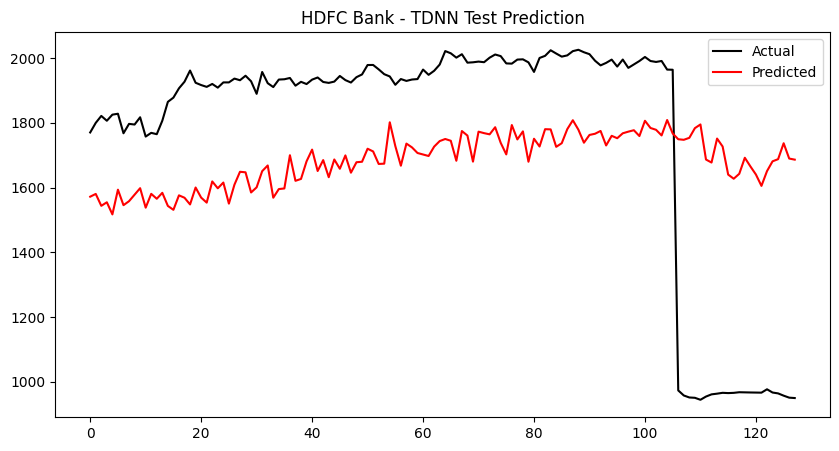


Processing TCS for TDNN-only model

Training TDNN Model for TCS
Training MSE: 49460.9402, MAE: 172.2750, R²: 0.6801
Testing  MSE: 57630.9003, MAE: 199.1986, R²: -0.5741


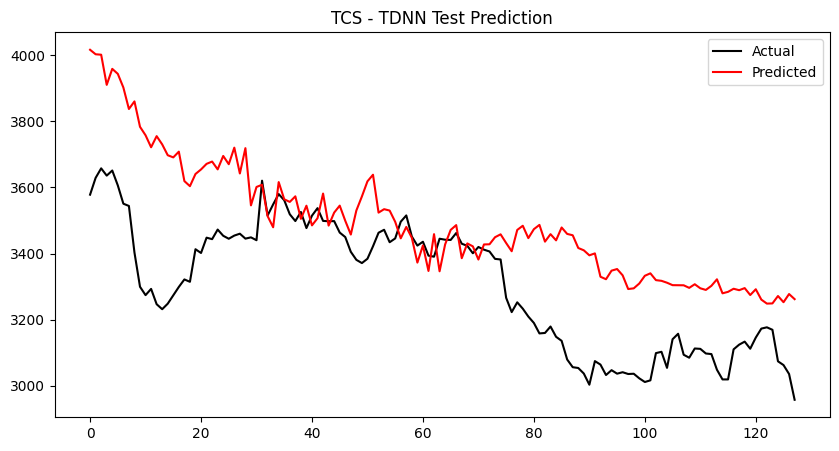


Processing Maruti Suzuki for TDNN-only model

Training TDNN Model for Maruti Suzuki
Training MSE: 471589.8080, MAE: 544.3381, R²: 0.7413
Testing  MSE: 2055240.5307, MAE: 1114.6824, R²: -0.3457


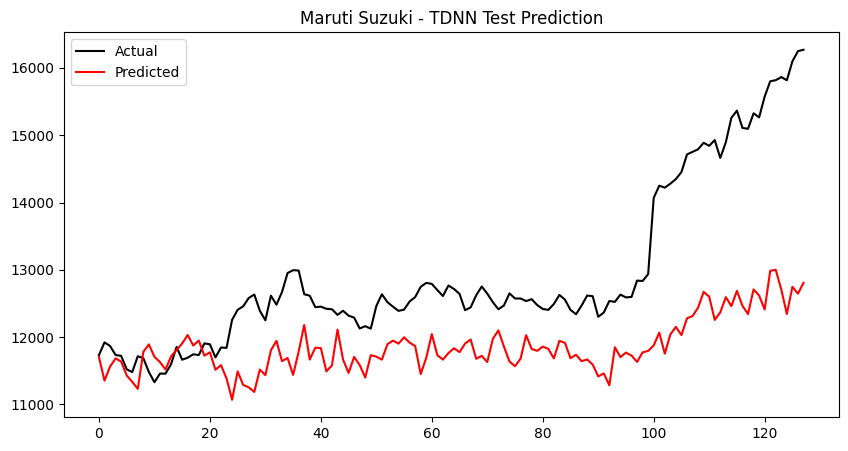


Processing Asian Paints for TDNN-only model

Training TDNN Model for Asian Paints
Training MSE: 100544.1717, MAE: 293.9076, R²: 0.1229
Testing  MSE: 38477.9189, MAE: 175.6282, R²: -3.0011


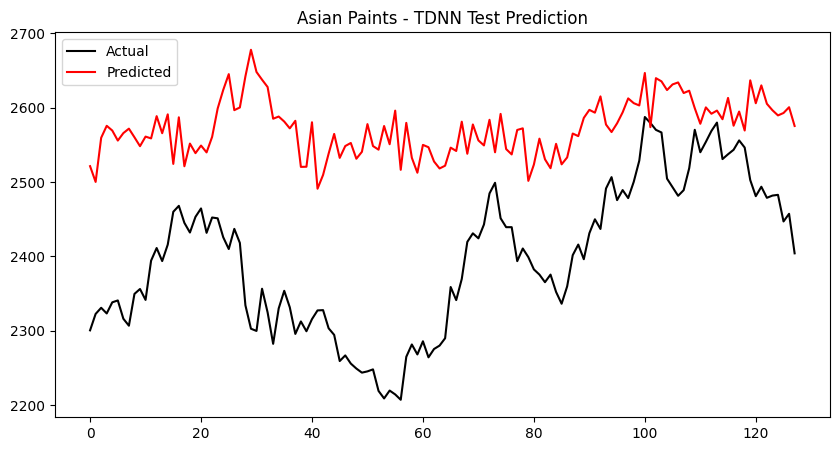


Processing Dabur for TDNN-only model

Training TDNN Model for Dabur
Training MSE: 1288.0496, MAE: 30.1579, R²: 0.2051
Testing  MSE: 537.3540, MAE: 19.9816, R²: 0.1326


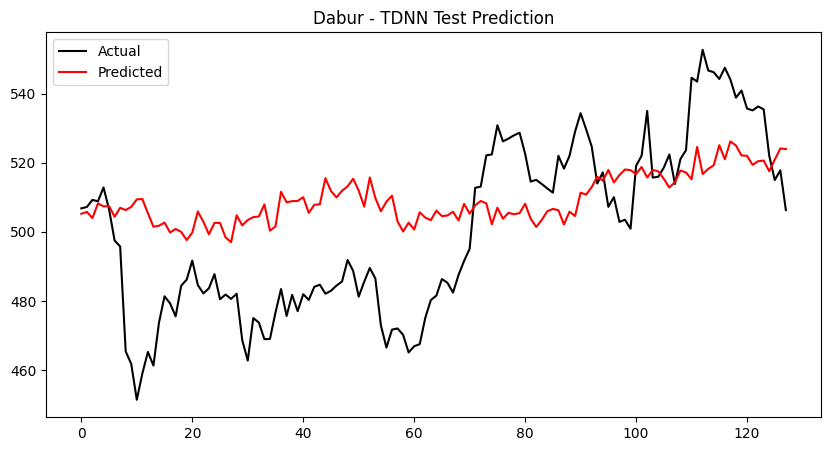


Processing Dr. Reddy's for TDNN-only model

Training TDNN Model for Dr. Reddy's
Training MSE: 2311408.8083, MAE: 1268.7856, R²: 0.3657
Testing  MSE: 1901801.3919, MAE: 1376.9945, R²: -507.4562


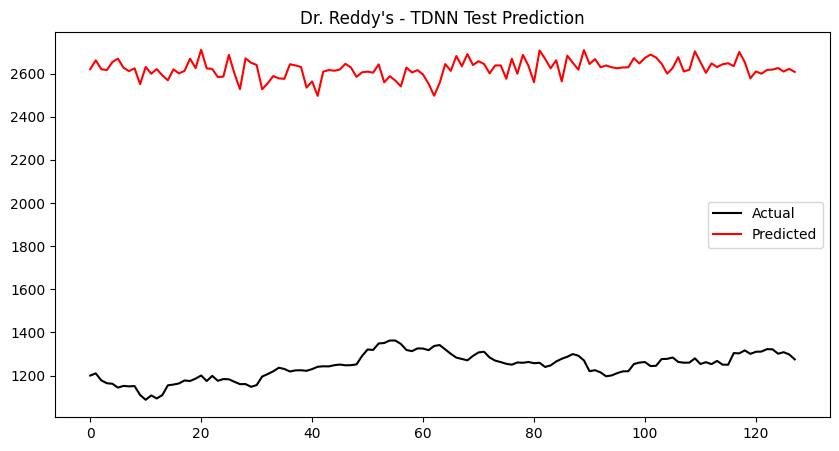


Processing Apollo Hospitals for TDNN-only model

Training TDNN Model for Apollo Hospitals
Training MSE: 303507.0952, MAE: 450.5815, R²: 0.6203
Testing  MSE: 891876.1697, MAE: 918.6463, R²: -5.0950


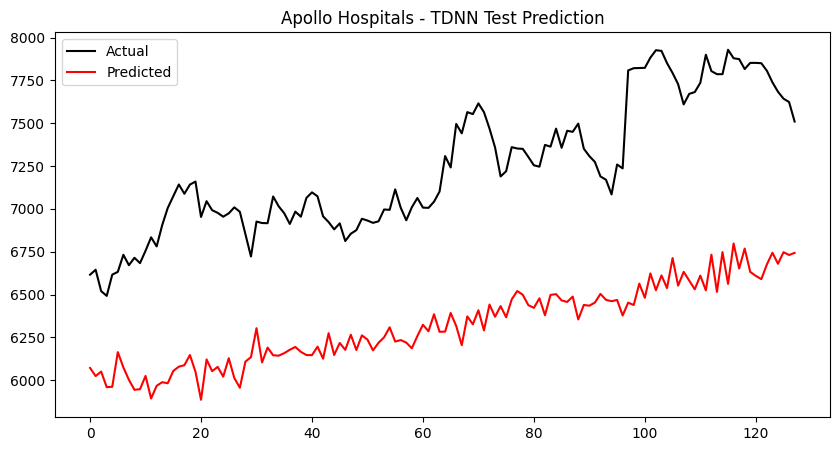


Processing Airtel for TDNN-only model

Training TDNN Model for Airtel
Training MSE: 10229.2828, MAE: 81.3401, R²: 0.9035
Testing  MSE: 15789.1069, MAE: 102.0273, R²: -1.9050


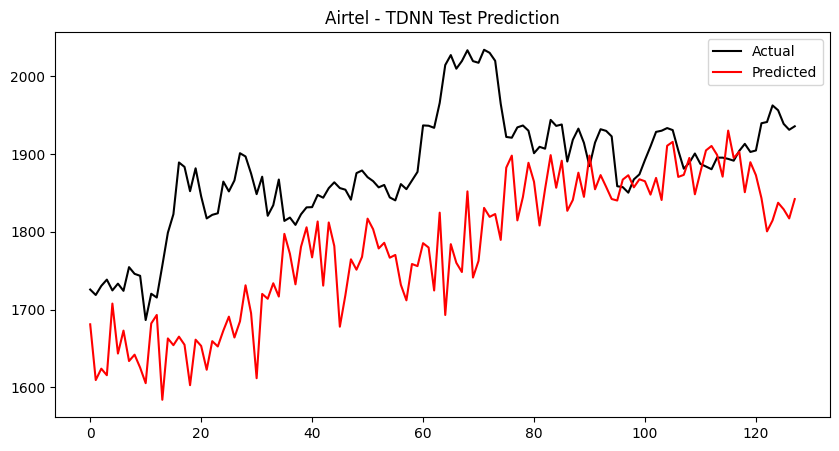


Processing Mazagon Dock for TDNN-only model

Training TDNN Model for Mazagon Dock
Training MSE: 689372.1278, MAE: 646.8110, R²: 0.5955
Testing  MSE: 597768.2880, MAE: 723.3750, R²: -5.3028


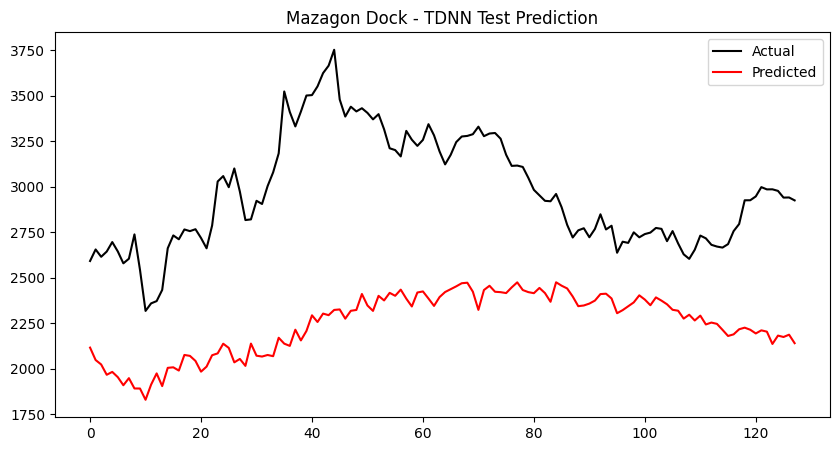


Processing Motilal Oswal for TDNN-only model

Training TDNN Model for Motilal Oswal
Training MSE: 23993.3074, MAE: 105.1500, R²: 0.9041
Testing  MSE: 6462.0210, MAE: 64.9243, R²: 0.4995


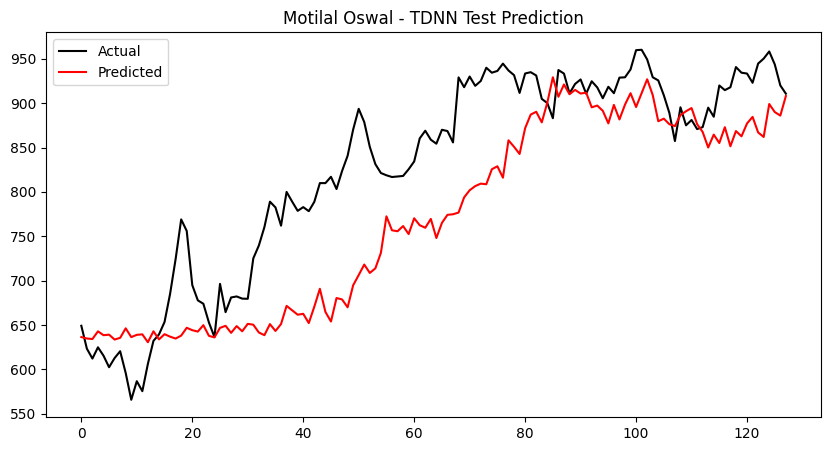


TDNN SUMMARY
HDFC Bank: MSE=150646.3664, MAE=340.2152, R²=-0.0776
TCS: MSE=57630.9003, MAE=199.1986, R²=-0.5741
Maruti Suzuki: MSE=2055240.5307, MAE=1114.6824, R²=-0.3457
Asian Paints: MSE=38477.9189, MAE=175.6282, R²=-3.0011
Dabur: MSE=537.3540, MAE=19.9816, R²=0.1326
Dr. Reddy's: MSE=1901801.3919, MAE=1376.9945, R²=-507.4562
Apollo Hospitals: MSE=891876.1697, MAE=918.6463, R²=-5.0950
Airtel: MSE=15789.1069, MAE=102.0273, R²=-1.9050
Mazagon Dock: MSE=597768.2880, MAE=723.3750, R²=-5.3028
Motilal Oswal: MSE=6462.0210, MAE=64.9243, R²=0.4995


In [21]:
def create_tdnn_only_model(df, stock_name, target_col='CLOSE', sequence_length=60):
    print(f"\n{'='*60}")
    print(f"Training TDNN Model for {stock_name}")
    print(f"{'='*60}")
    
    df_processed = df.copy()
    df_processed.index = pd.to_datetime(df_processed['Date'])
    
    df_processed['Open-Close'] = df_processed['OPEN'] - df_processed['CLOSE']
    df_processed['High-Low'] = df_processed['HIGH'] - df_processed['LOW']
    df_processed['Price_Change'] = df_processed['CLOSE'].pct_change()
    df_processed['SMA_5'] = df_processed['CLOSE'].rolling(window=5).mean()
    df_processed['SMA_10'] = df_processed['CLOSE'].rolling(window=10).mean()
    df_processed['Volatility'] = df_processed['Price_Change'].rolling(window=10).std()
    df_processed.dropna(inplace=True)
    
    feature_cols = ['Open-Close', 'High-Low', 'Price_Change', 'SMA_5', 'SMA_10', 'Volatility']
    features = df_processed[feature_cols].values
    target = df_processed[target_col].values

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    features_scaled = scaler_X.fit_transform(features)
    target_scaled = scaler_y.fit_transform(target.reshape(-1, 1)).flatten()

    X, y = [], []
    for i in range(sequence_length, len(features_scaled)):
        X.append(features_scaled[i-sequence_length:i].flatten())
        y.append(target_scaled[i])
    X, y = np.array(X), np.array(y)

    split_point = int(0.8 * len(X))
    X_train, X_test = X[:split_point], X[split_point:]
    y_train, y_test = y[:split_point], y[split_point:]

    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

    history = model.fit(
        X_train, y_train,
        epochs=80,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    y_pred_train_scaled = model.predict(X_train, verbose=0).flatten()
    y_pred_test_scaled = model.predict(X_test, verbose=0).flatten()

    y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled.reshape(-1, 1)).flatten()
    y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()
    y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

    train_mse = mean_squared_error(y_train_actual, y_pred_train)
    test_mse = mean_squared_error(y_test_actual, y_pred_test)
    train_mae = mean_absolute_error(y_train_actual, y_pred_train)
    test_mae = mean_absolute_error(y_test_actual, y_pred_test)
    train_r2 = r2_score(y_train_actual, y_pred_train)
    test_r2 = r2_score(y_test_actual, y_pred_test)

    print(f"Training MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
    print(f"Testing  MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, R²: {test_r2:.4f}")
    
    plt.figure(figsize=(10,5))
    plt.plot(y_test_actual, label='Actual', color='black')
    plt.plot(y_pred_test, label='Predicted', color='red')
    plt.title(f"{stock_name} - TDNN Test Prediction")
    plt.legend()
    plt.show()
    
    return {
        'model': model,
        'history': history,
        'train_predictions': y_pred_train,
        'test_predictions': y_pred_test,
        'train_actual': y_train_actual,
        'test_actual': y_test_actual,
        'mse': test_mse,
        'mae': test_mae,
        'r2': test_r2
    }


tdnn_results_all = {}
for stock_name, df in stocks_data.items():
    try:
        print(f"\n{'='*80}")
        print(f"Processing {stock_name} for TDNN-only model")
        print(f"{'='*80}")
        result = create_tdnn_only_model(df, stock_name)
        tdnn_results_all[stock_name] = result
    except Exception as e:
        print(f"Error processing {stock_name}: {str(e)}")
        import traceback
        traceback.print_exc()

print(f"\n{'='*80}")
print(f"TDNN SUMMARY")
print(f"{'='*80}")
for stock_name, result in tdnn_results_all.items():
    print(f"{stock_name}: MSE={result['mse']:.4f}, MAE={result['mae']:.4f}, R²={result['r2']:.4f}")

In [22]:
def create_hybrid_arima_tdnn_model(df, stock_name, target_col='CLOSE', sequence_length=60):
    """
    Create a hybrid ARIMA-TDNN model that combines ARIMA for linear patterns
    and TDNN for capturing non-linear residuals with temporal dependencies
    """
    print(f"\n{'='*60}")
    print(f"Creating Hybrid ARIMA-TDNN Model for {stock_name}")
    print(f"{'='*60}")
    
    df_processed = df.copy()
    df_processed.index = pd.to_datetime(df_processed['Date'])
    
    df_processed['Open-Close'] = df_processed['OPEN'] - df_processed['CLOSE']
    df_processed['High-Low'] = df_processed['HIGH'] - df_processed['LOW']
    df_processed['Price_Change'] = df_processed['CLOSE'].pct_change()
    df_processed['SMA_5'] = df_processed['CLOSE'].rolling(window=5).mean()
    df_processed['SMA_10'] = df_processed['CLOSE'].rolling(window=10).mean()
    df_processed['Volatility'] = df_processed['Price_Change'].rolling(window=10).std()
    
    target_data = df_processed[target_col].dropna()
    
    split_point = int(0.8 * len(target_data))
    train_target = target_data[:split_point]
    test_target = target_data[split_point:]
    
    # Step 1: Fit ARIMA model
    try:
        arima_model = ARIMA(train_target, order=(1, 1, 1))
        arima_fitted = arima_model.fit()
        
        arima_pred_train = arima_fitted.fittedvalues
        arima_pred_test = arima_fitted.forecast(steps=len(test_target))
        
        print(f"ARIMA model fitted successfully")
        print(f"ARIMA AIC: {arima_fitted.aic:.2f}")
        
    except Exception as e:
        print(f"ARIMA model failed: {str(e)}")
        arima_pred_train = train_target.rolling(window=5).mean().fillna(train_target.mean())
        arima_pred_test = np.full(len(test_target), train_target.mean())
    
    # Calculate ARIMA residuals
    arima_residuals_train = train_target - arima_pred_train
    arima_residuals_test = test_target - arima_pred_test
    
    # Step 2: Prepare TDNN data for residual prediction
    feature_cols = ['Open-Close', 'High-Low', 'Price_Change', 'SMA_5', 'SMA_10', 'Volatility']
    features = df_processed[feature_cols].fillna(method='ffill').fillna(0)

    common_index = target_data.index.intersection(features.index)
    features_aligned = features.loc[common_index].values
    residuals_aligned_train = arima_residuals_train.loc[common_index[:split_point]]
    residuals_aligned_test = arima_residuals_test.loc[common_index[split_point:]]
    
    # Scale features for TDNN
    scaler_features = MinMaxScaler()
    scaler_residuals = MinMaxScaler()
    
    features_scaled = scaler_features.fit_transform(features_aligned)
    residuals_scaled_train = scaler_residuals.fit_transform(residuals_aligned_train.values.reshape(-1, 1)).flatten()
    residuals_scaled_test = scaler_residuals.transform(residuals_aligned_test.values.reshape(-1, 1)).flatten()
    
    # Create TDNN sequences: flatten time-delayed windows
    X_train, y_train_tdnn = [], []
    X_test, y_test_tdnn = [], []
    
    for i in range(sequence_length, split_point):
        X_train.append(features_scaled[i-sequence_length:i].flatten())
        y_train_tdnn.append(residuals_scaled_train[i])
    
    for i in range(sequence_length, len(residuals_scaled_test)):
        test_idx = split_point + i - sequence_length
        if test_idx < len(features_scaled):
            X_test.append(features_scaled[test_idx-sequence_length:test_idx].flatten())
            y_test_tdnn.append(residuals_scaled_test[i])
    
    X_train, y_train_tdnn = np.array(X_train), np.array(y_train_tdnn)
    X_test, y_test_tdnn = np.array(X_test), np.array(y_test_tdnn)
    
    # Adjust test target to match TDNN output length
    if len(y_test_tdnn) < len(test_target):
        test_target_adjusted = test_target.iloc[:len(y_test_tdnn)]
        arima_pred_test_adjusted = arima_pred_test[:len(y_test_tdnn)]
    else:
        test_target_adjusted = test_target
        arima_pred_test_adjusted = arima_pred_test
    
    # Step 3: Create and train TDNN model
    def create_tdnn_model(input_dim):
        model = Sequential([
            Dense(128, activation='relu', input_shape=(input_dim,)),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dropout(0.2),
            Dense(16, activation='relu'),
            Dense(1)
        ])
        
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
        return model
    
    if len(X_train) > 0:
        tdnn_model = create_tdnn_model(X_train.shape[1])
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
        
        history = tdnn_model.fit(
            X_train, y_train_tdnn,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping, reduce_lr],
            verbose=0
        )
        
        tdnn_residuals_train_scaled = tdnn_model.predict(X_train, verbose=0).flatten()
        tdnn_residuals_test_scaled = tdnn_model.predict(X_test, verbose=0).flatten()
        
        # Inverse transform TDNN residuals
        tdnn_residuals_train = scaler_residuals.inverse_transform(tdnn_residuals_train_scaled.reshape(-1, 1)).flatten()
        tdnn_residuals_test = scaler_residuals.inverse_transform(tdnn_residuals_test_scaled.reshape(-1, 1)).flatten()
        
        # Adjust train predictions to match length
        if len(tdnn_residuals_train) < len(train_target):
            train_target_adjusted = train_target.iloc[-len(tdnn_residuals_train):]
            arima_pred_train_adjusted = arima_pred_train.iloc[-len(tdnn_residuals_train):]
            hybrid_pred_train = arima_pred_train_adjusted + tdnn_residuals_train
        else:
            train_target_adjusted = train_target
            hybrid_pred_train = arima_pred_train + tdnn_residuals_train[:len(train_target)]
        
        hybrid_pred_test = arima_pred_test_adjusted + tdnn_residuals_test
        
        # Calculate metrics
        train_mse = mean_squared_error(train_target_adjusted, hybrid_pred_train)
        test_mse = mean_squared_error(test_target_adjusted, hybrid_pred_test)
        train_mae = mean_absolute_error(train_target_adjusted, hybrid_pred_train)
        test_mae = mean_absolute_error(test_target_adjusted, hybrid_pred_test)
        train_r2 = r2_score(train_target_adjusted, hybrid_pred_train)
        test_r2 = r2_score(test_target_adjusted, hybrid_pred_test)
    else:
        print("Warning: Insufficient data for TDNN. Using ARIMA predictions only.")
        hybrid_pred_train = arima_pred_train
        hybrid_pred_test = arima_pred_test
        train_target_adjusted = train_target
        test_target_adjusted = test_target
        arima_pred_test_adjusted = arima_pred_test
        history = None
        tdnn_model = None
        tdnn_residuals_test = None
        
        # Calculate metrics using ARIMA only
        train_mse = mean_squared_error(train_target_adjusted, hybrid_pred_train)
        test_mse = mean_squared_error(test_target_adjusted, hybrid_pred_test)
        train_mae = mean_absolute_error(train_target_adjusted, hybrid_pred_train)
        test_mae = mean_absolute_error(test_target_adjusted, hybrid_pred_test)
        train_r2 = r2_score(train_target_adjusted, hybrid_pred_train)
        test_r2 = r2_score(test_target_adjusted, hybrid_pred_test)
    
    print(f"\nHybrid ARIMA-TDNN Performance for {stock_name}:")
    print(f"Training MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
    print(f"Testing MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, R²: {test_r2:.4f}")
    
    return {
        'arima_model': arima_fitted if 'arima_fitted' in locals() else None,
        'tdnn_model': tdnn_model,
        'history': history,
        'predictions': hybrid_pred_test,
        'actual': test_target_adjusted.values,
        'mse': test_mse,
        'mae': test_mae,
        'r2': test_r2,
        'train_predictions': hybrid_pred_train,
        'train_actual': train_target_adjusted.values,
        'arima_predictions': arima_pred_test_adjusted,
        'tdnn_residuals': tdnn_residuals_test if 'tdnn_residuals_test' in locals() and tdnn_residuals_test is not None else None
    }

# Initialize dictionary to store results for all stocks
hybrid_results_all = {}

# Process all stocks
for stock_name, df in stocks_data.items():
    try:
        print(f"\n{'='*80}")
        print(f"Processing {stock_name} for Hybrid ARIMA-TDNN")
        print(f"{'='*80}")
        
        hybrid_result = create_hybrid_arima_tdnn_model(df, stock_name)
        hybrid_results_all[stock_name] = hybrid_result
        
        print(f"Hybrid ARIMA-TDNN model completed for {stock_name}")
        
    except Exception as e:
        print(f"Error processing {stock_name}: {str(e)}")
        import traceback
        traceback.print_exc()
        continue

print(f"\n{'='*80}")
print(f"HYBRID ARIMA-TDNN SUMMARY")
print(f"{'='*80}")
print(f"Successfully processed {len(hybrid_results_all)} stocks")

for stock_name, result in hybrid_results_all.items():
    print(f"{stock_name}: MSE={result['mse']:.4f}, MAE={result['mae']:.4f}, R²={result['r2']:.4f}")



Processing HDFC Bank for Hybrid ARIMA-TDNN

Creating Hybrid ARIMA-TDNN Model for HDFC Bank
ARIMA model fitted successfully
ARIMA AIC: 7353.35


c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.




Hybrid ARIMA-TDNN Performance for HDFC Bank:
Training MSE: 56910.5472, MAE: 221.2659, R²: -1.0251
Testing MSE: 117502.7157, MAE: 327.3718, R²: -9.8878
Hybrid ARIMA-TDNN model completed for HDFC Bank

Processing TCS for Hybrid ARIMA-TDNN

Creating Hybrid ARIMA-TDNN Model for TCS
ARIMA model fitted successfully
ARIMA AIC: 6272.98


c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.




Hybrid ARIMA-TDNN Performance for TCS:
Training MSE: 3122.0005, MAE: 42.7026, R²: 0.9805
Testing MSE: 194977.1588, MAE: 423.6169, R²: -11.1057
Hybrid ARIMA-TDNN model completed for TCS

Processing Maruti Suzuki for Hybrid ARIMA-TDNN

Creating Hybrid ARIMA-TDNN Model for Maruti Suzuki
ARIMA model fitted successfully
ARIMA AIC: 7572.55


c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.




Hybrid ARIMA-TDNN Performance for Maruti Suzuki:
Training MSE: 24419.2531, MAE: 111.3674, R²: 0.9887
Testing MSE: 421444.6582, MAE: 511.9081, R²: -1.0448
Hybrid ARIMA-TDNN model completed for Maruti Suzuki

Processing Asian Paints for Hybrid ARIMA-TDNN

Creating Hybrid ARIMA-TDNN Model for Asian Paints
ARIMA model fitted successfully
ARIMA AIC: 5954.59


c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.




Hybrid ARIMA-TDNN Performance for Asian Paints:
Training MSE: 1255.2717, MAE: 25.8201, R²: 0.9860
Testing MSE: 12837.7142, MAE: 90.6458, R²: -1.2021
Hybrid ARIMA-TDNN model completed for Asian Paints

Processing Dabur for Hybrid ARIMA-TDNN

Creating Hybrid ARIMA-TDNN Model for Dabur
ARIMA model fitted successfully
ARIMA AIC: 4047.11


c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.




Hybrid ARIMA-TDNN Performance for Dabur:
Training MSE: 52.6056, MAE: 5.1977, R²: 0.9634
Testing MSE: 1320.2900, MAE: 33.3981, R²: -5.3895
Hybrid ARIMA-TDNN model completed for Dabur

Processing Dr. Reddy's for Hybrid ARIMA-TDNN

Creating Hybrid ARIMA-TDNN Model for Dr. Reddy's
ARIMA model fitted successfully
ARIMA AIC: 8124.93


c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.




Hybrid ARIMA-TDNN Performance for Dr. Reddy's:
Training MSE: 237121.8191, MAE: 433.5003, R²: 0.9183
Testing MSE: 24554.1508, MAE: 139.0280, R²: -3.5083
Hybrid ARIMA-TDNN model completed for Dr. Reddy's

Processing Apollo Hospitals for Hybrid ARIMA-TDNN

Creating Hybrid ARIMA-TDNN Model for Apollo Hospitals
ARIMA model fitted successfully
ARIMA AIC: 6939.83


c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.




Hybrid ARIMA-TDNN Performance for Apollo Hospitals:
Training MSE: 6866.8393, MAE: 58.8858, R²: 0.9926
Testing MSE: 344724.5194, MAE: 518.2762, R²: -1.9550
Hybrid ARIMA-TDNN model completed for Apollo Hospitals

Processing Airtel for Hybrid ARIMA-TDNN

Creating Hybrid ARIMA-TDNN Model for Airtel
ARIMA model fitted successfully
ARIMA AIC: 4970.25


c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.




Hybrid ARIMA-TDNN Performance for Airtel:
Training MSE: 1088.0456, MAE: 28.8838, R²: 0.9899
Testing MSE: 17195.8609, MAE: 113.2847, R²: -0.3931
Hybrid ARIMA-TDNN model completed for Airtel

Processing Mazagon Dock for Hybrid ARIMA-TDNN

Creating Hybrid ARIMA-TDNN Model for Mazagon Dock
ARIMA model fitted successfully
ARIMA AIC: 7598.16


c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.




Hybrid ARIMA-TDNN Performance for Mazagon Dock:
Training MSE: 78957.1333, MAE: 238.7200, R²: 0.9582
Testing MSE: 1019183.7139, MAE: 870.4803, R²: -3.5125
Hybrid ARIMA-TDNN model completed for Mazagon Dock

Processing Motilal Oswal for Hybrid ARIMA-TDNN

Creating Hybrid ARIMA-TDNN Model for Motilal Oswal
ARIMA model fitted successfully
ARIMA AIC: 6937.32


c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\home\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.




Hybrid ARIMA-TDNN Performance for Motilal Oswal:
Training MSE: 160180.0931, MAE: 392.5171, R²: 0.3344
Testing MSE: 270267.5339, MAE: 511.1367, R²: -24.7838
Hybrid ARIMA-TDNN model completed for Motilal Oswal

HYBRID ARIMA-TDNN SUMMARY
Successfully processed 10 stocks
HDFC Bank: MSE=117502.7157, MAE=327.3718, R²=-9.8878
TCS: MSE=194977.1588, MAE=423.6169, R²=-11.1057
Maruti Suzuki: MSE=421444.6582, MAE=511.9081, R²=-1.0448
Asian Paints: MSE=12837.7142, MAE=90.6458, R²=-1.2021
Dabur: MSE=1320.2900, MAE=33.3981, R²=-5.3895
Dr. Reddy's: MSE=24554.1508, MAE=139.0280, R²=-3.5083
Apollo Hospitals: MSE=344724.5194, MAE=518.2762, R²=-1.9550
Airtel: MSE=17195.8609, MAE=113.2847, R²=-0.3931
Mazagon Dock: MSE=1019183.7139, MAE=870.4803, R²=-3.5125
Motilal Oswal: MSE=270267.5339, MAE=511.1367, R²=-24.7838


In [23]:
print("\nAll processes completed.")


All processes completed.


This project has given a comprehensive implementation of various stock price prediction models including SARIMAX, SVR, XGBoost, LSTM, TDNN, and a hybrid ARIMA-TDNN model. Each model has been trained, evaluated, and visualized to provide insights into their performance. The visualizations help in comparing the effectiveness of each model across different stocks. Further enhancements can include hyperparameter tuning, ensemble methods, and real-time data integration for more robust predictions.

**Key Models Implemented:**
1. SARIMAX - Seasonal ARIMA with exogenous variables
2. SVR - Support Vector Regression
3. XGBoost - Gradient Boosting for regression
4. LSTM - Long Short-Term Memory networks
5. TDNN - Time Delay Neural Networks
6. Hybrid ARIMA-TDNN - Combines ARIMA for linear patterns with TDNN for non-linear residual modeling

The implication of all results and why they occur for different stocks will be explained in detail at ppt with proper academic research.
